In [2]:
import scanpy as sc

In [8]:
adata = sc.read_h5ad('../../data/RREAE_5k_raw_integration_processed.h5ad')

/Users/christoffer/miniconda3/envs/sc/lib/python3.8/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [9]:
adata.layers['raw'].max()

1401.0

In [10]:
import pandas as pd

# 1) coerce to plain string Index (not categorical)
if isinstance(adata.obs.index, pd.CategoricalIndex):
    adata.obs.index = adata.obs.index.astype(str)
else:
    adata.obs.index = adata.obs.index.astype(str)

# 2) now this will work
adata.obs_names_make_unique()

In [11]:
def gene_counts_per_celltype_distance(
    adata,
    gene,
    celltype_col="celltype_merged",
    distance_col="lesion_distance_bin",
    layer=None,
    use_raw=True
):
    """
    For a given gene, compute per (celltype, distance_bin):
      - total counts of the gene
      - number of cells
      - mean counts per cell
    """
    from scipy import sparse
    import numpy as np
    import pandas as pd

    # choose matrix and var_names
    if use_raw:
        if adata.raw is None:
            raise ValueError("use_raw=True but adata.raw is None")
        X = adata.raw.X
        var_names = np.asarray(adata.raw.var_names)
    elif layer is not None:
        X = adata.layers[layer]
        var_names = np.asarray(adata.var_names)
    else:
        X = adata.X
        var_names = np.asarray(adata.var_names)

    # locate gene index
    if gene not in var_names:
        raise ValueError(f"Gene {gene} not found in var_names")
    g_idx = np.where(var_names == gene)[0][0]

    # extract gene counts per cell
    if sparse.issparse(X):
        gene_counts = np.asarray(X[:, g_idx].toarray()).ravel()
    else:
        gene_counts = np.asarray(X[:, g_idx]).ravel()

    # assemble df
    df = adata.obs[[celltype_col, distance_col]].copy()
    df["gene_counts"] = gene_counts

    grouped = (df.groupby([celltype_col, distance_col])
                 .agg(total_gene_counts=("gene_counts", "sum"),
                      n_cells=(celltype_col, "count"))
                 .reset_index())

    grouped["mean_gene_counts_per_cell"] = (
        grouped["total_gene_counts"] / grouped["n_cells"]
    )

    grouped["gene"] = gene
    return grouped

In [12]:
df_slc16a3 = gene_counts_per_celltype_distance(
    adata,
    gene="Slc16a3",
    celltype_col="celltype_merged",
    distance_col="lesion_distance_bin",
    use_raw=False, 
    layer = 'raw'
)

# Just astrocytes
df_slc16a3.query("celltype_merged == 'Astrocyte'")

celltype_merged lesion_distance_bin  total_gene_counts  n_cells  \
7        Astrocyte              0–10µm              654.0     2554   
8        Astrocyte             10–25µm              372.0     1316   
9        Astrocyte             25–50µm              535.0     2233   
10       Astrocyte            50–100µm              879.0     4118   
11       Astrocyte           100–200µm             1193.0     8410   
12       Astrocyte           200–500µm             2112.0    26481   
13       Astrocyte              >500µm             1772.0    33846   

    mean_gene_counts_per_cell     gene  
7                    0.256069  Slc16a3  
8                    0.282675  Slc16a3  
9                    0.239588  Slc16a3  
10                   0.213453  Slc16a3  
11                   0.141855  Slc16a3  
12                   0.079755  Slc16a3  
13                   0.052355  Slc16a3

In [50]:
df_slc16a3 = gene_counts_per_celltype_distance(
    adata,
    gene="Hibadh",
    celltype_col="celltype_merged",
    distance_col="lesion_distance_bin",
    use_raw=False, 
    layer = 'raw'
)

# Just astrocytes
df_slc16a3.query("celltype_merged == 'Astrocyte'")

celltype_merged lesion_distance_bin  total_gene_counts  n_cells  \
8        Astrocyte              0–10µm              564.0     2554   
9        Astrocyte             10–25µm              381.0     1316   
10       Astrocyte             25–50µm              641.0     2233   
11       Astrocyte            50–100µm             1212.0     4118   
12       Astrocyte           100–200µm             2596.0     8410   
13       Astrocyte           200–500µm             9318.0    26481   
14       Astrocyte              >500µm            13116.0    33846   
15       Astrocyte                 NaN             7218.0    17920   

    mean_gene_counts_per_cell    gene  
8                    0.220830  Hibadh  
9                    0.289514  Hibadh  
10                   0.287058  Hibadh  
11                   0.294318  Hibadh  
12                   0.308680  Hibadh  
13                   0.351875  Hibadh  
14                   0.387520  Hibadh  
15                   0.402790  Hibadh

In [13]:
df_slc16a3 = gene_counts_per_celltype_distance(
    adata,
    gene="Lrig1",
    celltype_col="celltype_merged",
    distance_col="lesion_distance_bin",
    use_raw=False, 
    layer = 'raw'
)

# Just astrocytes
df_slc16a3.query("celltype_merged == 'Astrocyte'")

celltype_merged lesion_distance_bin  total_gene_counts  n_cells  \
7        Astrocyte              0–10µm             1209.0     2554   
8        Astrocyte             10–25µm              821.0     1316   
9        Astrocyte             25–50µm             1532.0     2233   
10       Astrocyte            50–100µm             3133.0     4118   
11       Astrocyte           100–200µm             7324.0     8410   
12       Astrocyte           200–500µm            30208.0    26481   
13       Astrocyte              >500µm            33659.0    33846   

    mean_gene_counts_per_cell   gene  
7                    0.473375  Lrig1  
8                    0.623860  Lrig1  
9                    0.686073  Lrig1  
10                   0.760806  Lrig1  
11                   0.870868  Lrig1  
12                   1.140742  Lrig1  
13                   0.994475  Lrig1

In [14]:
df_slc16a3 = gene_counts_per_celltype_distance(
    adata,
    gene="Ldha",
    celltype_col="celltype_merged",
    distance_col="lesion_distance_bin",
    use_raw=False, 
    layer = 'raw'
)

# Just astrocytes
df_slc16a3.query("celltype_merged == 'Astrocyte'")

celltype_merged lesion_distance_bin  total_gene_counts  n_cells  \
7        Astrocyte              0–10µm             1944.0     2554   
8        Astrocyte             10–25µm             1202.0     1316   
9        Astrocyte             25–50µm             1894.0     2233   
10       Astrocyte            50–100µm             3138.0     4118   
11       Astrocyte           100–200µm             5476.0     8410   
12       Astrocyte           200–500µm            14867.0    26481   
13       Astrocyte              >500µm            17313.0    33846   

    mean_gene_counts_per_cell  gene  
7                    0.761159  Ldha  
8                    0.913374  Ldha  
9                    0.848186  Ldha  
10                   0.762020  Ldha  
11                   0.651130  Ldha  
12                   0.561421  Ldha  
13                   0.511523  Ldha

In [15]:
genes = ['Hif1a','Hk2','Pfkl','Pdk1','Pkm','Ldha','Ldhb','Slc16a1','Slc16a3','Serpina3n','Ppargc1a',"Mfn1","Mfn2","Opa1",'Sirt2']


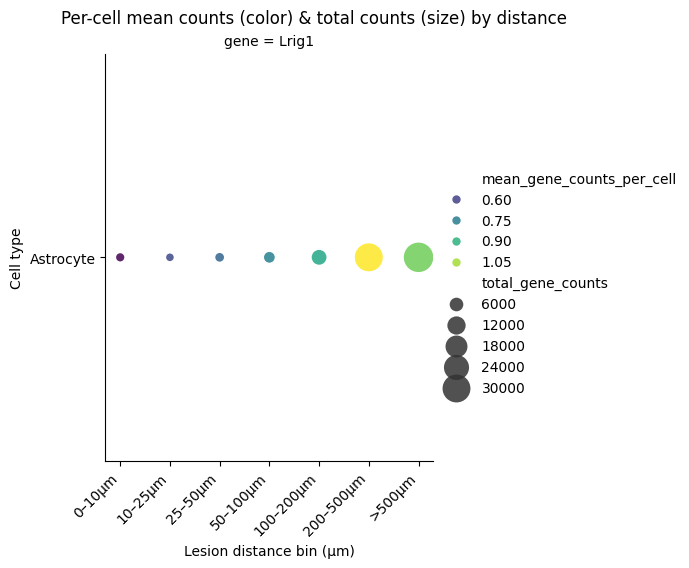

In [17]:
import re, numpy as np, pandas as pd, seaborn as sns, matplotlib.pyplot as plt
from scipy import sparse

# --- helper: compute per-gene counts by (celltype, distance bin)
def gene_counts_per_celltype_distance(adata, gene, celltype_col="celltype_merged",
                                      distance_col="lesion_distance_bin",
                                      use_raw=False, layer="raw"):
    if use_raw:
        if adata.raw is None: raise ValueError("use_raw=True but adata.raw is None")
        X = adata.raw.X; var_names = np.asarray(adata.raw.var_names)
    else:
        X = adata.layers[layer] if layer is not None else adata.X
        var_names = np.asarray(adata.var_names)

    if gene not in var_names:
        return pd.DataFrame(columns=[celltype_col, distance_col, "total_gene_counts", "n_cells",
                                     "mean_gene_counts_per_cell", "gene"])

    g_idx = np.where(var_names == gene)[0][0]
    if sparse.issparse(X):
        # ensure subscriptable & dense col
        X = X.tocsr()
        gene_counts = np.asarray(X[:, g_idx].toarray()).ravel()
    else:
        gene_counts = np.asarray(X[:, g_idx]).ravel()

    df = adata.obs[[celltype_col, distance_col]].copy()
    df["gene_counts"] = gene_counts

    out = (df.groupby([celltype_col, distance_col], dropna=False)
             .agg(total_gene_counts=("gene_counts","sum"),
                  n_cells=(celltype_col,"count"))
             .reset_index())
    out["mean_gene_counts_per_cell"] = out["total_gene_counts"] / out["n_cells"].replace(0, np.nan)
    out["gene"] = gene
    return out

# --- helper: natural sort of distance bins like "0-25 µm", "25-50 µm", ...
def _bin_key(s):
    if s is None or (isinstance(s, float) and np.isnan(s)): return (float("inf"),)
    m = re.search(r"(\d+)", str(s))
    return (int(m.group(1)) if m else float("inf"),)

# --- main: build tidy df for selected genes & celltypes and plot
def plot_distance_dotplot(adata, genes_subset, celltypes_subset=None,
                          celltype_col="celltype_merged", distance_col="lesion_distance_bin",
                          use_raw=False, layer="raw", sizes=(20, 300), cmap="viridis"):
    # gather
    frames = []
    for g in genes_subset:
        frames.append(
            gene_counts_per_celltype_distance(
                adata, g, celltype_col=celltype_col, distance_col=distance_col,
                use_raw=use_raw, layer=layer
            )
        )
    df = pd.concat(frames, ignore_index=True) if frames else pd.DataFrame()

    # subset cell types (optional)
    if celltypes_subset is not None:
        df = df[df[celltype_col].isin(celltypes_subset)].copy()

    # order axes
    # distance bins
    bins = sorted(df[distance_col].dropna().unique(), key=_bin_key)
    df[distance_col] = pd.Categorical(df[distance_col], categories=bins, ordered=True)
    # celltypes (keep provided order if subset given, else alphabetical)
    if celltypes_subset is not None:
        df[celltype_col] = pd.Categorical(df[celltype_col], categories=celltypes_subset, ordered=True)
    else:
        df[celltype_col] = pd.Categorical(df[celltype_col], ordered=True)

    # plot (one column per gene)
    g = sns.relplot(
        data=df,
        x=distance_col, y=celltype_col,
        hue="mean_gene_counts_per_cell",
        size="total_gene_counts",
        col="gene", kind="scatter",
        palette=cmap, sizes=sizes, alpha=0.85, edgecolor="none"
    )
    g.set_xticklabels(rotation=45, ha="right")
    g.set_ylabels("Cell type")
    g.set_xlabels("Lesion distance bin (µm)")
    g.figure.suptitle("Per-cell mean counts (color) & total counts (size) by distance", y=1.02)
    plt.show()
    return df  # return the tidy data used for the plot

# --- usage examples ---
# choose any subset you like:
genes_subset = ["Lrig1"]
celltypes_subset = ["Astrocyte"]  # or None for all

df_dot = plot_distance_dotplot(
    adata,
    genes_subset=genes_subset,
    celltypes_subset=celltypes_subset,
    celltype_col="celltype_merged",
    distance_col="lesion_distance_bin",
    use_raw=False, layer="raw",   # set use_raw=True if your adata.raw has counts
    sizes=(30, 450),              # tweak size range if needed
    cmap="viridis"
)
# df_dot contains total_gene_counts, n_cells, mean_gene_counts_per_cell per (celltype, bin, gene)

In [18]:
adata.obs.celltype_merged.unique()

['Neuron', 'T cell', 'APC/Myeloid', 'B cell', 'Monocyte', ..., 'Dendritic cell', 'Mixed glia-vascular', 'T cell (cycling)', 'Fibroblast (cycling)', 'Metabolic-like']
Length: 21
Categories (21, object): ['APC/Myeloid', 'Astrocyte', 'B cell', 'Dendritic cell', ..., 'Oligodendrocyte', 'Pericyte', 'T cell', 'T cell (cycling)']

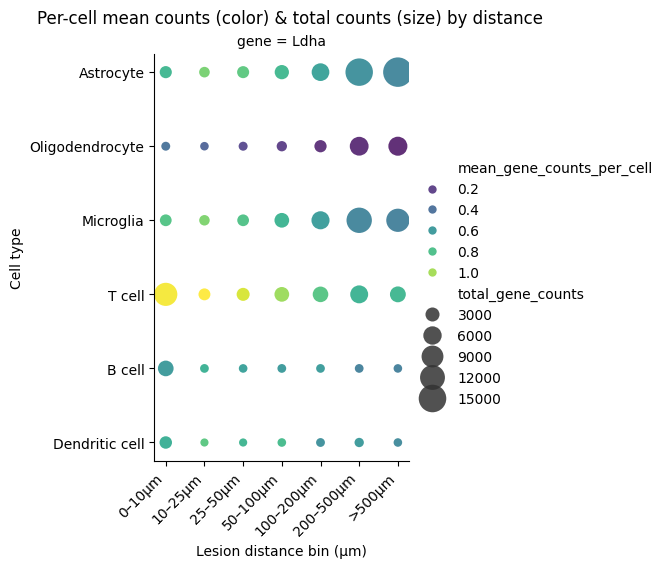

In [19]:
genes_subset = ["Ldha"]
celltypes_subset = ["Astrocyte", 'Oligodendrocyte','Microglia','T cell','B cell','Dendritic cell']  # or None for all

df_dot = plot_distance_dotplot(
    adata,
    genes_subset=genes_subset,
    celltypes_subset=celltypes_subset,
    celltype_col="celltype_merged",
    distance_col="lesion_distance_bin",
    use_raw=False, layer="raw",   # set use_raw=True if your adata.raw has counts
    sizes=(30, 450),              # tweak size range if needed
    cmap="viridis"
)

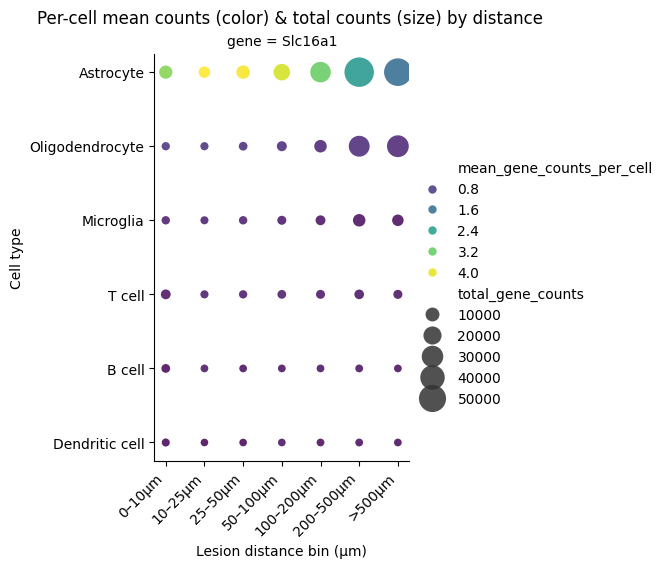

In [20]:
genes_subset = ["Slc16a1"]
celltypes_subset = ["Astrocyte", 'Oligodendrocyte','Microglia','T cell','B cell','Dendritic cell']  # or None for all

df_dot = plot_distance_dotplot(
    adata,
    genes_subset=genes_subset,
    celltypes_subset=celltypes_subset,
    celltype_col="celltype_merged",
    distance_col="lesion_distance_bin",
    use_raw=False, layer="raw",   # set use_raw=True if your adata.raw has counts
    sizes=(30, 450),              # tweak size range if needed
    cmap="viridis"
)

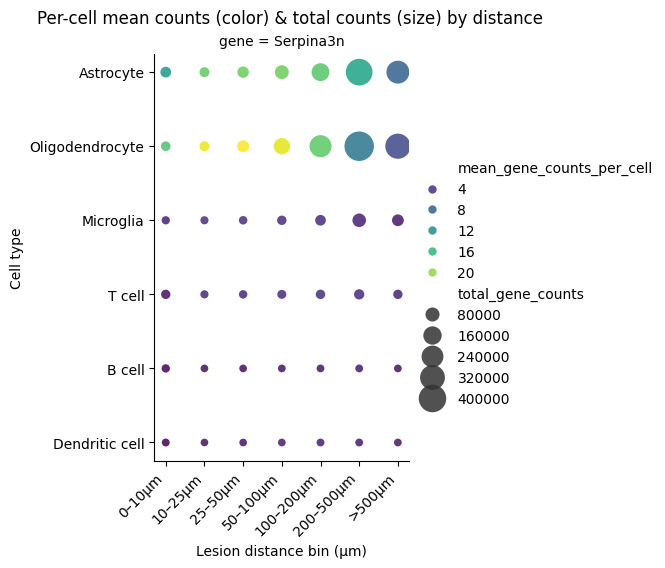

In [21]:
genes_subset = ["Serpina3n"]
celltypes_subset = ["Astrocyte", 'Oligodendrocyte','Microglia','T cell','B cell','Dendritic cell']  # or None for all

df_dot = plot_distance_dotplot(
    adata,
    genes_subset=genes_subset,
    celltypes_subset=celltypes_subset,
    celltype_col="celltype_merged",
    distance_col="lesion_distance_bin",
    use_raw=False, layer="raw",   # set use_raw=True if your adata.raw has counts
    sizes=(30, 450),              # tweak size range if needed
    cmap="viridis"
)

In [23]:
genes = ['Hif1a','Hk2','Pfkl','Pdk1','Pkm','Ldha','Ldhb','Slc16a1','Slc16a3','Serpina3n','Ppargc1a',"Mfn1","Mfn2","Opa1",'Sirt2','Lrig1']


Neuron


/Users/christoffer/miniconda3/envs/sc/lib/python3.8/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


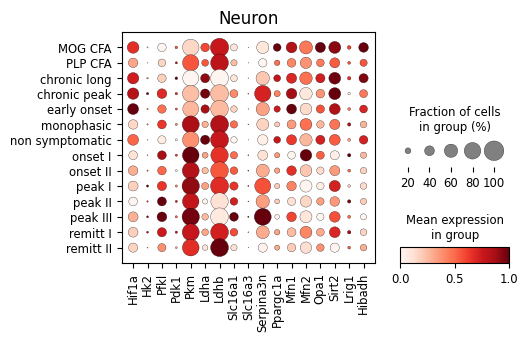

/Users/christoffer/miniconda3/envs/sc/lib/python3.8/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


T cell


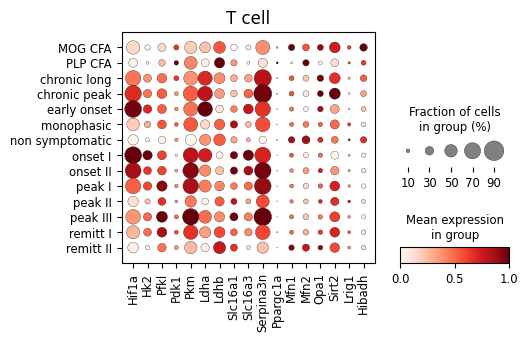

APC/Myeloid


/Users/christoffer/miniconda3/envs/sc/lib/python3.8/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


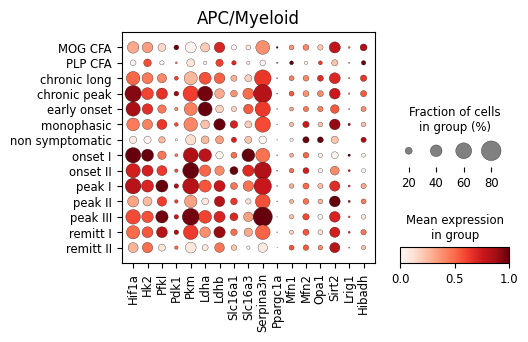

/Users/christoffer/miniconda3/envs/sc/lib/python3.8/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


B cell


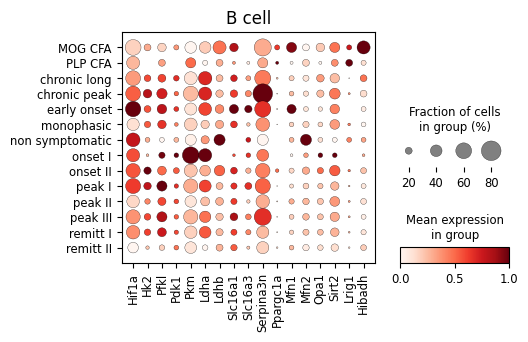

Monocyte


/Users/christoffer/miniconda3/envs/sc/lib/python3.8/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


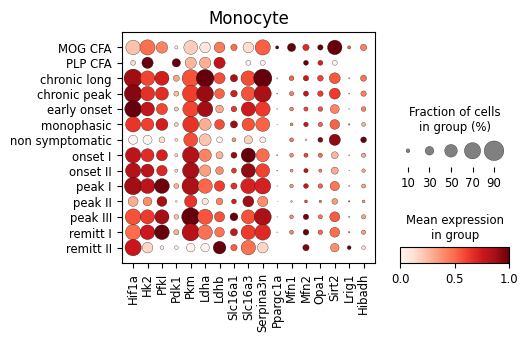

Endothelial


/Users/christoffer/miniconda3/envs/sc/lib/python3.8/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


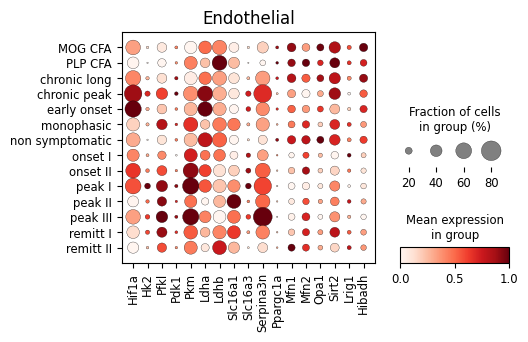

Oligodendrocyte


/Users/christoffer/miniconda3/envs/sc/lib/python3.8/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


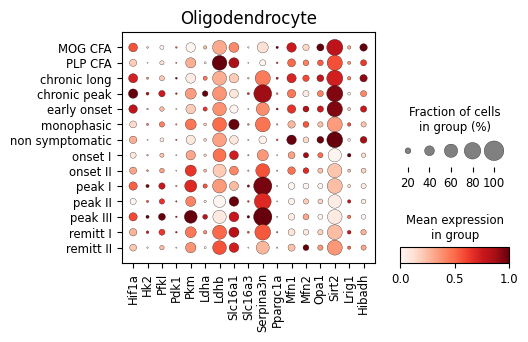

Fibroblast


/Users/christoffer/miniconda3/envs/sc/lib/python3.8/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


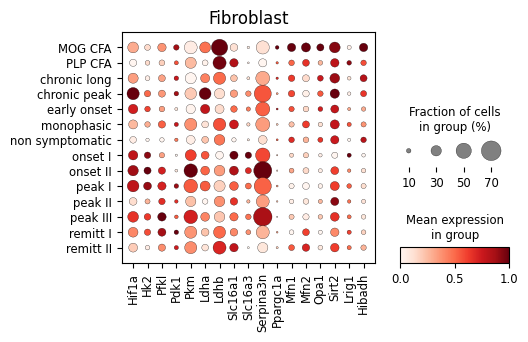

Astrocyte


/Users/christoffer/miniconda3/envs/sc/lib/python3.8/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


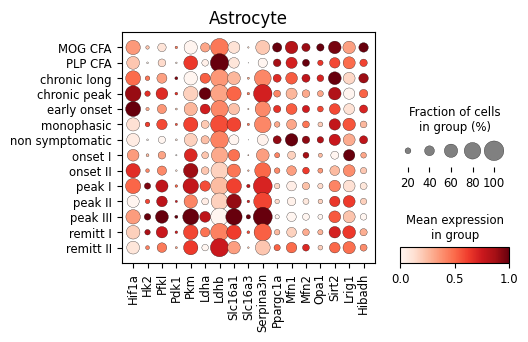

/Users/christoffer/miniconda3/envs/sc/lib/python3.8/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


Ependymal


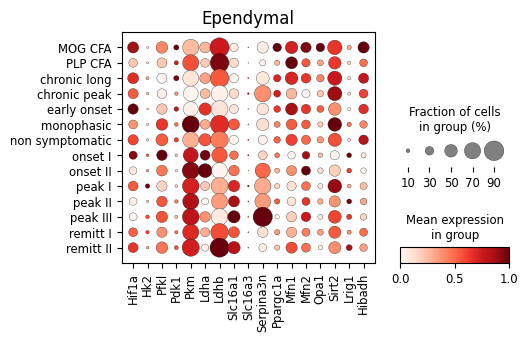

Glial-like


/Users/christoffer/miniconda3/envs/sc/lib/python3.8/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


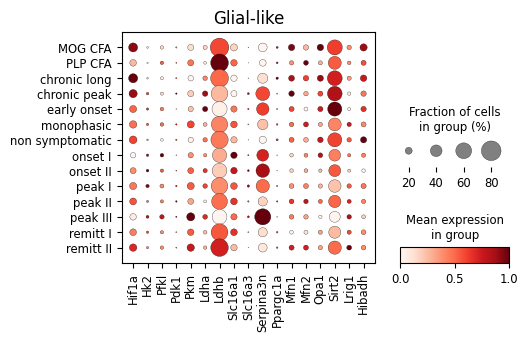

/Users/christoffer/miniconda3/envs/sc/lib/python3.8/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


Foamy Myeloid


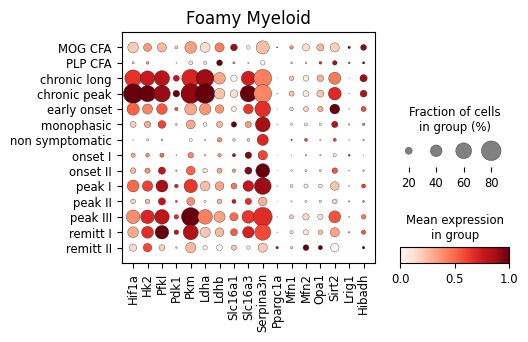

/Users/christoffer/miniconda3/envs/sc/lib/python3.8/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


Monocyte (inflammatory)


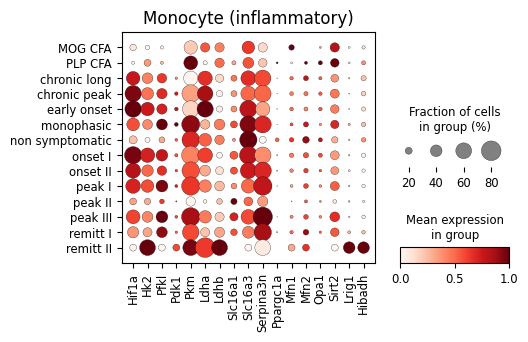

Microglia


/Users/christoffer/miniconda3/envs/sc/lib/python3.8/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


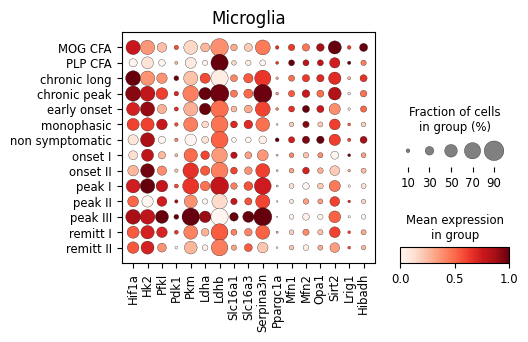

/Users/christoffer/miniconda3/envs/sc/lib/python3.8/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


Pericyte


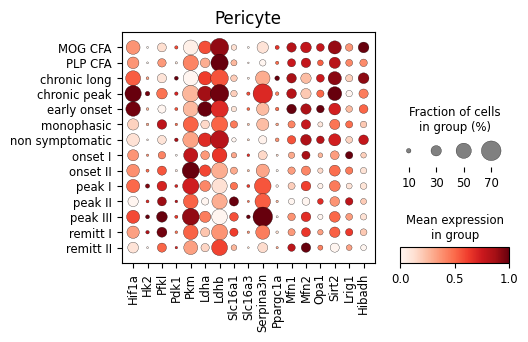

OPC


/Users/christoffer/miniconda3/envs/sc/lib/python3.8/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


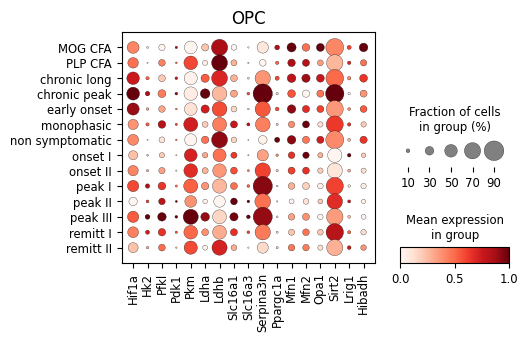

/Users/christoffer/miniconda3/envs/sc/lib/python3.8/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


Dendritic cell


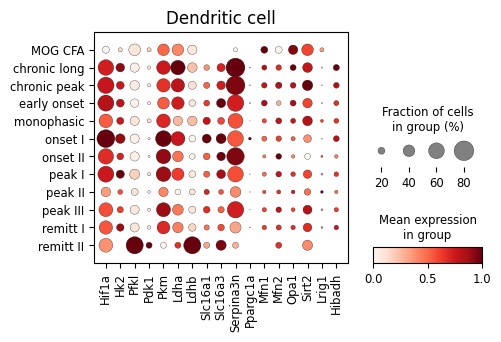

Mixed glia-vascular


/Users/christoffer/miniconda3/envs/sc/lib/python3.8/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


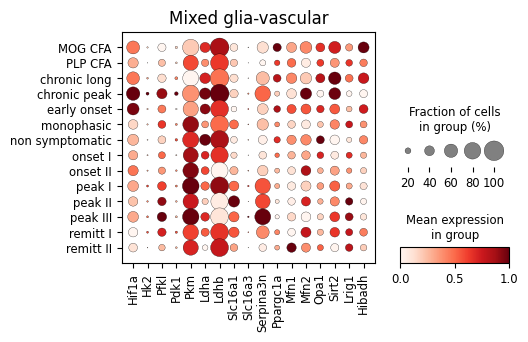

/Users/christoffer/miniconda3/envs/sc/lib/python3.8/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


T cell (cycling)


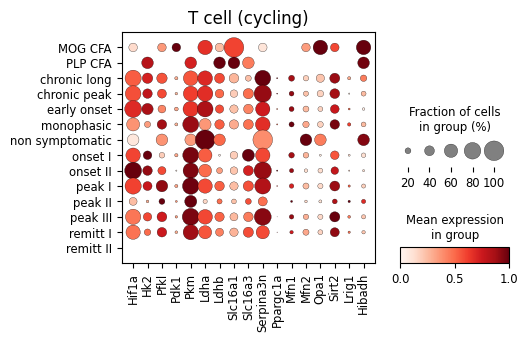

Fibroblast (cycling)


/Users/christoffer/miniconda3/envs/sc/lib/python3.8/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


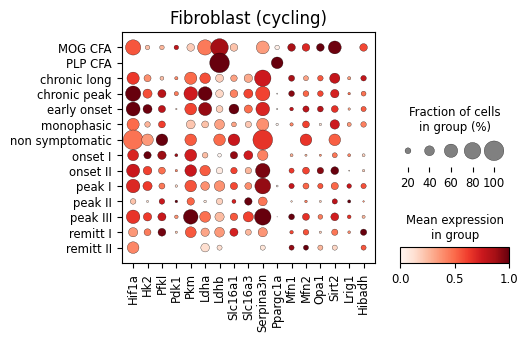

Metabolic-like


/Users/christoffer/miniconda3/envs/sc/lib/python3.8/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


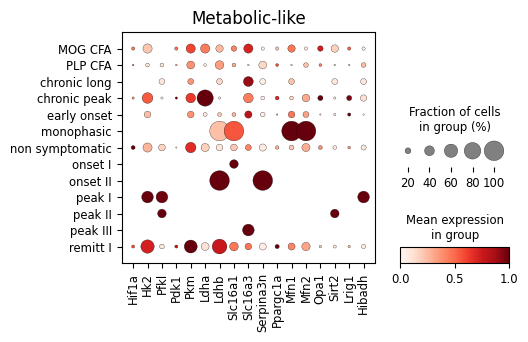

In [49]:
genes = ['Hif1a','Hk2','Pfkl','Pdk1','Pkm','Ldha','Ldhb','Slc16a1','Slc16a3','Serpina3n','Ppargc1a',"Mfn1","Mfn2","Opa1",'Sirt2','Lrig1', 'Hibadh']

for cell in adata.obs.celltype_merged.unique():
    print(cell)
    # Create dotplot (returns a dict of Figures when var_names is a dict)
    sc.pl.dotplot(
        adata[adata.obs.celltype_merged == cell],
        var_names=genes,
        groupby="course",
        standard_scale="var",
        #dot_max=0.5,
        #dot_min=0.05,
        color_map="Reds",
        dendrogram=False,
        figsize=(5, 3),
        #categories_order=['Ctrl','Early','Peak','Late'],
        title=cell
    )


/Users/christoffer/miniconda3/envs/sc/lib/python3.8/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


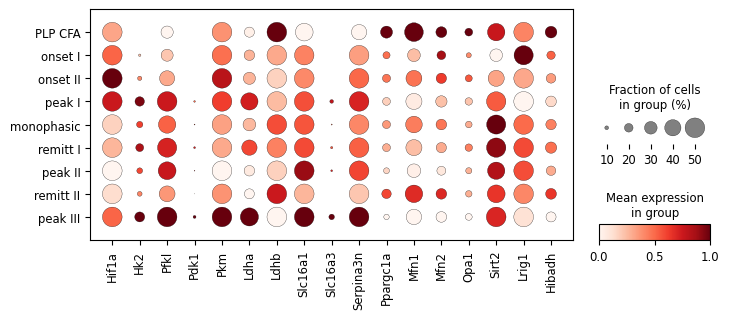

In [47]:
import scanpy as sc
import matplotlib as mpl
mpl.rcParams['svg.fonttype'] = 'none'  # keep text editable
adata_sub = adata[adata.obs.model == 'RR']
dp = sc.pl.dotplot(
    adata_sub[adata_sub.obs.celltype_merged == 'Astrocyte'],
    var_names=genes,
    groupby="course",
    standard_scale="var",
    dot_max=0.5, dot_min=0.05, color_map="Reds",
    dendrogram=False,
    categories_order=['PLP CFA','onset I','onset II','peak I','monophasic','remitt I','peak II','remitt II','peak III'],
    figsize=(8,3),
)
#dp.savefig("../../data/plots/bioenergetic_map_RR.svg")

In [45]:
genes = ['Hif1a',
 'Hk2',
 'Pfkl',
 'Pdk1',
 'Pkm',
 'Ldha',
 'Ldhb',
 'Slc16a1',
 'Slc16a3',
 'Serpina3n',
 'Ppargc1a',
 'Mfn1',
 'Mfn2',
 'Opa1',
 'Sirt2',
 'Lrig1',
        'Hibadh']

/Users/christoffer/miniconda3/envs/sc/lib/python3.8/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


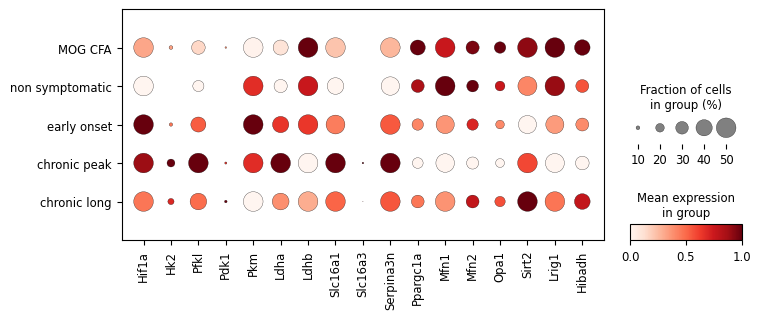

In [46]:
import scanpy as sc
import matplotlib as mpl
mpl.rcParams['svg.fonttype'] = 'none'  # keep text editable
adata_sub = adata[adata.obs.model == 'Chronic']
dp = sc.pl.dotplot(
    adata_sub[adata_sub.obs.celltype_merged == 'Astrocyte'],
    var_names=genes,
    groupby="course",
    standard_scale="var",
    dot_max=0.5, dot_min=0.05, color_map="Reds",
    dendrogram=False,
    categories_order=['MOG CFA',
                      'non symptomatic',
                      'early onset',
                      'chronic peak',
                      'chronic long'],
    figsize=(8,3),
)
#dp.savefig("../../data/plots/bioenergetic_map_RR.svg")

In [19]:
mask = (adata.obs["model"] == "Chronic") & (adata.obs["course"] == "remitt II")
adata.obs.loc[mask, "model"] = "RR"


In [ ]:
dp = sc.pl.dotplot(
    adata[adata.obs.model == 'Chronic'],
    var_names=genes,
    groupby="course",
    standard_scale="var",
    dot_max=0.5, dot_min=0.05, color_map="Reds",
    dendrogram=False,
    categories_order=['MOG CFA',
                      'non symptomatic',
                      'early onset',
                      'chronic peak',
                      'chronic long'],
    figsize=(6, 3),
)
#dp.savefig("../../data/plots/bioenergetic_map_Chronic.svg", bbox_inches="tight")

/Users/christoffer/miniconda3/envs/sc/lib/python3.8/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


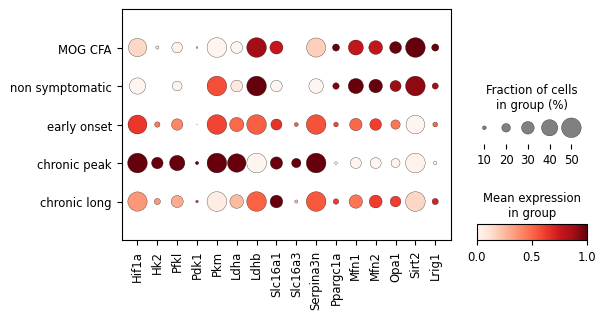

In [26]:
dp = sc.pl.dotplot(
    adata[adata.obs.model == 'Chronic'],
    var_names=genes,
    groupby="course",
    standard_scale="var",
    dot_max=0.5, dot_min=0.05, color_map="Reds",
    dendrogram=False,
    categories_order=['MOG CFA',
                      'non symptomatic',
                      'early onset',
                      'chronic peak',
                      'chronic long'],
    figsize=(6, 3),
)
#dp.savefig("../../data/plots/bioenergetic_map_Chronic.svg", bbox_inches="tight")

/Users/christoffer/miniconda3/envs/sc/lib/python3.8/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


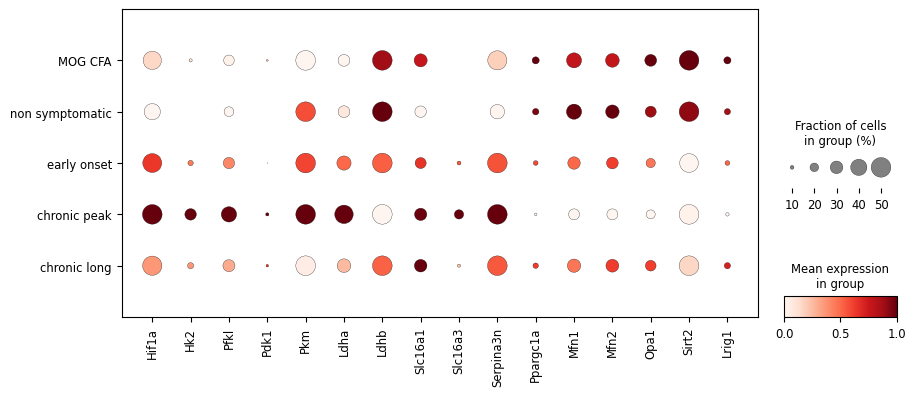

In [27]:
dp = sc.pl.dotplot(
    adata[adata.obs.model == 'Chronic'],
    var_names=genes,
    groupby="course",
    standard_scale="var",
    dot_max=0.5, dot_min=0.05, color_map="Reds",
    dendrogram=False,
    categories_order=['MOG CFA',
                      'non symptomatic',
                      'early onset',
                      'chronic peak',
                      'chronic long'],
    figsize=(10, 4),
)
#dp.savefig("../../data/plots/bioenergetic_map_Chronic.svg", bbox_inches="tight")

In [28]:
ordered_cell_types = [
    'Neuron',                      # Excitatory/inhibitory signal transmission, main targets of neurodegeneration
    'OPC',                         # Oligodendrocyte precursor cells, proliferative, remyelination potential
    'OPC (cycling)',               # Actively dividing OPCs during repair or inflammation
    'Oligodendrocyte',              # Myelinating glia, maintain axonal conduction, metabolically support neurons
    'DA-Oligodendrocyte',          # Disease-associated oligodendrocytes, altered myelin/lipid metabolism
    'Astrocyte',                   # Structural/metabolic support, blood-brain barrier maintenance, neurotransmitter cycling
    'DA-Astrocyte',                # Reactive astrocytes with pro- or anti-inflammatory phenotypes
    'Ependymal',                   # Line ventricles/central canal, regulate cerebrospinal fluid composition
    'Microglia (homeostatic)',     # CNS-resident immune cells in surveillance mode
    'Microglia (intermediate)',    # Transitional activation states, partly inflammatory
    'Microglia (cycling)',         # Proliferating microglia during inflammatory expansion
    'Foamy Microglia',             # Lipid-laden microglia, often in demyelinated lesions
    'Monocyte',                    # Peripheral immune cells infiltrating CNS, non-inflammatory phenotype
    'Monocyte (inflammatory)',     # Infiltrating monocytes with pro-inflammatory transcriptional profile
    'APC/Myeloid',                  # Antigen-presenting myeloid cells, drive adaptive immune activation
    'Foamy Myeloid',               # Lipid-rich infiltrating myeloid cells, linked to chronic lesions
    'Dendritic cell',              # Professional antigen-presenting cells, activate T cells
    'T cell',                      # Adaptive immunity, immune surveillance
    'T cell (cycling)',            # Activated, proliferating T cxells during immune response
    'B cell',                      # Adaptive immunity, antibody production, antigen presentation
    'Endothelial',                 # Vascular lining cells, blood-brain barrier integrity
    'Pericyte',                    # Perivascular support, regulate blood flow and BBB permeability
    'Fibroblast',                  # ECM production, scar formation, meningeal fibrosis
    'Fibroblast (cycling)',        # Actively dividing fibroblasts in fibrosis/repair
    'Mixed glia-vascular',         # Hybrid or transitional population at glia–vascular interfaces
    'Glial-like',                  # Ambiguous glial phenotype, potentially progenitor or transitional
    'Metabolic-like'               # High metabolic activity, unclear lineage or specialized role
]

In [29]:
adata.X

<891821x5101 sparse matrix of type '<class 'numpy.float32'>'
	with 528065583 stored elements in Compressed Sparse Row format>

/Users/christoffer/miniconda3/envs/sc/lib/python3.8/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


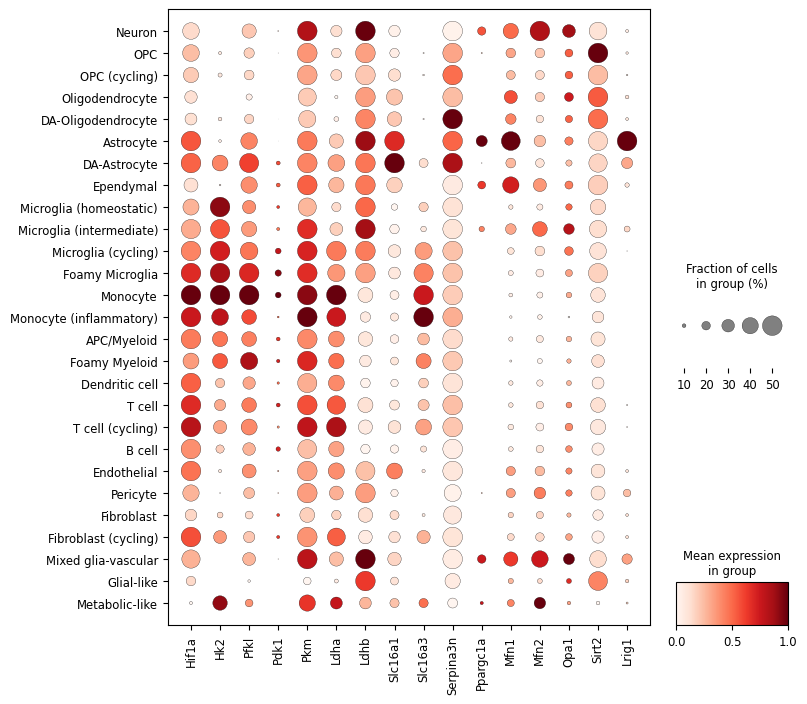

In [30]:
dp = sc.pl.dotplot(
    adata,
    var_names=genes,
    groupby="sub_type_III",
    standard_scale="var",
    dot_max=0.5, dot_min=0.05, color_map="Reds",
    dendrogram=False,
    figsize=(8, 8),
    #vmin=-5,
    vmax=1,
    categories_order = ordered_cell_types,
)
#dp.savefig("../../data/plots/bioenergetic_map_Chronic.svg", bbox_inches="tight")

In [25]:
list(adata.obs.celltype_merged.unique())

['Neuron',
 'T cell',
 'APC/Myeloid',
 'B cell',
 'Monocyte',
 'Endothelial',
 'Oligodendrocyte',
 'Fibroblast',
 'Astrocyte',
 'Ependymal',
 'Glial-like',
 'Foamy Myeloid',
 'Monocyte (inflammatory)',
 'Microglia',
 'Pericyte',
 'OPC',
 'Dendritic cell',
 'Mixed glia-vascular',
 'T cell (cycling)',
 'Fibroblast (cycling)',
 'Metabolic-like']

In [26]:
merge_map = {
    "Fibroblast (cycling)": "Fibroblast",
    
}

celltype_col = "sub_type_III"
adata.obs["celltype_merged"] = adata.obs[celltype_col].replace(merge_map)


In [151]:
genes = [
    'Hif1a',
    'Hk2',
    'Pfkl',
    'Pdk1',
    'Pkm',
    'Ldha',
    'Ldhb',
    'Slc16a1',
    'Slc16a3',
    'Serpina3n',
    'Ppargc1a',
    'Mfn1',
    'Mfn2',
    'Opa1',
    'Sirt2',
    'Mki67',
    'Tgfb1',
    "Pcna",
    "Mcm2",
    "Ccnb1","Cdc20","Plk1","Aurkb",
    "Top2a","Cenpa","Cenpe","Cenpf","Anln",
    "Col1a1","Fn1","Postn","Vcan",

    "Tgfb1",
    "Pdgfa","Pdgfb",
    # Reduced ECM degradation
    "Timp1",

 
    
]

/Users/christoffer/miniconda3/envs/sc/lib/python3.8/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


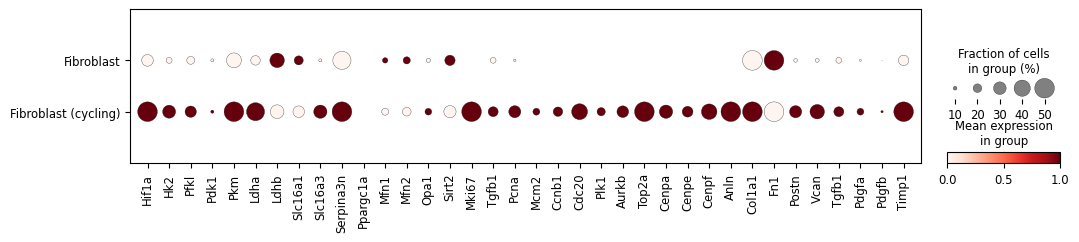

In [152]:
dp = sc.pl.dotplot(
    adata[adata.obs.sub_type_III.str.contains('Fibro')],
    var_names=genes,
    groupby="sub_type_III",
    standard_scale="var",
    dot_max=0.5, dot_min=0.05, color_map="Reds",
    dendrogram=False,
    figsize=(12, 2),
    #vmin=-5,
    vmax=1,
    #categories_order = ordered_cell_types,
)
#dp.savefig("../../data/plots/bioenergetic_map_Chronic.svg", bbox_inches="tight")

In [28]:
list(adata.obs.sub_type_III.unique())

['Neuron',
 'T cell',
 'APC/Myeloid',
 'B cell',
 'Monocyte',
 'Endothelial',
 'Oligodendrocyte',
 'DA-Oligodendrocyte',
 'Fibroblast',
 'Astrocyte',
 'DA-Astrocyte',
 'Ependymal',
 'Glial-like',
 'Foamy Myeloid',
 'Monocyte (inflammatory)',
 'Microglia (cycling)',
 'Pericyte',
 'Microglia (intermediate)',
 'Microglia (homeostatic)',
 'OPC',
 'Foamy Microglia',
 'Dendritic cell',
 'Mixed glia-vascular',
 'T cell (cycling)',
 'Fibroblast (cycling)',
 'OPC (cycling)',
 'Metabolic-like']

/Users/christoffer/miniconda3/envs/sc/lib/python3.8/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


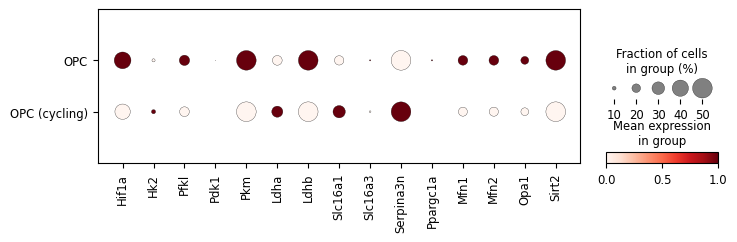

In [29]:
dp = sc.pl.dotplot(
    adata[adata.obs.sub_type_III.str.contains('OPC')],
    var_names=genes,
    groupby="sub_type_III",
    standard_scale="var",
    dot_max=0.5, dot_min=0.05, color_map="Reds",
    dendrogram=False,
    figsize=(8, 2),
    #vmin=-5,
    vmax=1,
    #categories_order = ordered_cell_types,
)
#dp.savefig("../../data/plots/bioenergetic_map_Chronic.svg", bbox_inches="tight")

/Users/christoffer/miniconda3/envs/sc/lib/python3.8/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


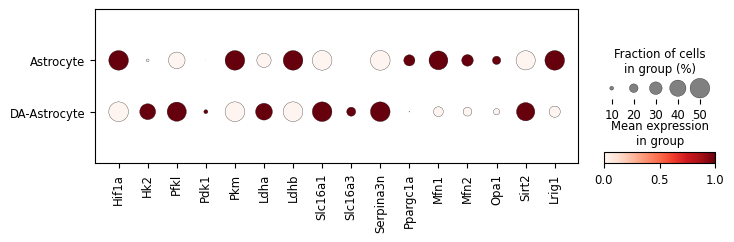

In [31]:
dp = sc.pl.dotplot(
    adata[adata.obs.sub_type_III.str.contains('Astr')],
    var_names=genes,
    groupby="sub_type_III",
    standard_scale="var",
    dot_max=0.5, dot_min=0.05, color_map="Reds",
    dendrogram=False,
    figsize=(8, 2),
    #vmin=-5,
    vmax=1,
    #categories_order = ordered_cell_types,
)
#dp.savefig("../../data/plots/bioenergetic_map_Chronic.svg", bbox_inches="tight")

In [36]:
fibro.X.max()

4.176707

In [37]:
fibro = adata[adata.obs["sub_type_III"].isin(["Fibroblast (cycling)", "Fibroblast"])].copy()

sc.tl.rank_genes_groups(
    fibro,
    groupby="sub_type_III",
    reference="Fibroblast",  # baseline group
    method="wilcoxon",
)



In [38]:
deg_two = sc.get.rank_genes_groups_df(fibro, group="Fibroblast (cycling)")
deg_two.head()

names     scores  logfoldchanges          pvals      pvals_adj
0      Mki67  36.125153        5.439973  9.138358e-286  4.661476e-282
1      Top2a  33.192932        5.524817  1.361534e-241  3.472592e-238
2      Lmnb1  30.110729        3.530182  3.506684e-199  5.962532e-196
3  Hist2h2bb  29.845678        3.366579  9.988656e-196  1.273803e-192
4       Anln  26.586580        4.023419  9.704160e-156  9.900185e-153

In [42]:
deg_two[deg_two.names.isin(genes)].sort_values(by = 'logfoldchanges',ascending=False)

names     scores  logfoldchanges         pvals     pvals_adj
89      Slc16a3  12.647724        1.947955  1.151620e-36  5.340376e-35
21        Hif1a  19.240215        1.420014  1.704997e-82  3.478876e-80
69         Ldha  13.835664        1.376359  1.552957e-43  9.211201e-42
181         Hk2   9.347613        1.159019  8.964758e-21  2.069196e-19
139         Pkm  10.530929        0.599649  6.221785e-26  1.855984e-24
732        Pfkl   4.380744        0.308342  1.182745e-05  7.156800e-05
224   Serpina3n   8.530653        0.175770  1.455234e-17  2.689547e-16
1285       Opa1   2.550223        0.121053  1.076541e-02  3.678122e-02
2982       Pdk1   0.105870        0.019607  9.156856e-01  9.999164e-01
1811       Mfn2   1.478287       -0.038180  1.393311e-01  3.314963e-01
1773       Mfn1   1.551352       -0.104672  1.208174e-01  2.945934e-01
1230    Slc16a1   2.687378       -0.130394  7.201530e-03  2.570679e-02
1700      Sirt2   1.698609       -0.171799  8.939296e-02  2.290274e-01
4908       Ldhb  -2.825862       -0.560329  4.715352e-03  1.750583e-02
4586   Ppargc1a  -0.731201       -0.959656  4.646565e-01  8.378271e-01

In [44]:
astro = adata[adata.obs["sub_type_III"].str.contains('Astro')].copy()

sc.tl.rank_genes_groups(
    astro,
    groupby="sub_type_III",
    reference="Astrocyte",  # baseline group
    method="wilcoxon",
)



/Users/christoffer/miniconda3/envs/sc/lib/python3.8/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [47]:
astro.obs.sub_type_III

cell_id
aadedgoa-1       Astrocyte
aaehedcl-1    DA-Astrocyte
aamfkdgh-1       Astrocyte
abhpnpan-1       Astrocyte
abjflace-1       Astrocyte
                  ...     
ohidokph-1       Astrocyte
ohijinoi-1       Astrocyte
ohikpojb-1       Astrocyte
ohjdbmif-1       Astrocyte
ohlngeln-1       Astrocyte
Name: sub_type_III, Length: 96878, dtype: category
Categories (2, object): ['Astrocyte', 'DA-Astrocyte']

In [51]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns

def deg_two_groups_by_pattern(
    adata,
    pattern,                 # e.g. "Astro" or "Oligo"
    groupby="sub_type_III",  # column with subtypes
    reference="Astrocyte",   # baseline subgroup name
    target="DA-Astrocyte",   # subgroup to extract
    genes=None,              # optional gene list to highlight
    method="wilcoxon",
    use_raw=True,
    layer=None,
    min_cells_per_group=5,
    sort_by="logfoldchanges",
    ascending=False,
    make_plot=True,
    top_n=20
):
    """
    Run DE between `target` vs `reference` groups within a celltype pattern.
    Returns a tidy dataframe. Optionally makes a volcano plot.
    """
    mask = adata.obs[groupby].astype(str).str.contains(pattern, na=False)
    sub = adata[mask].copy()
    if sub.n_obs == 0:
        raise ValueError(f"No cells found for pattern '{pattern}' in obs['{groupby}'].")

    groups_present = sub.obs[groupby].astype(str).unique().tolist()
    if reference not in groups_present or target not in groups_present:
        raise ValueError(f"Reference '{reference}' or target '{target}' not in {groups_present}")

    counts = sub.obs[groupby].value_counts()
    if counts.get(reference, 0) < min_cells_per_group or counts.get(target, 0) < min_cells_per_group:
        raise ValueError(f"Too few cells: {target}={counts.get(target,0)}, {reference}={counts.get(reference,0)}")

    sc.tl.rank_genes_groups(
        sub,
        groupby=groupby,
        reference=reference,
        method=method,
        use_raw=use_raw,
        layer=layer
    )

    deg = sc.get.rank_genes_groups_df(sub, group=target)
    if genes is not None:
        deg = deg[deg["names"].isin(genes)]

    if sort_by in deg.columns:
        deg = deg.sort_values(sort_by, ascending=ascending)

    if make_plot and not deg.empty:
        plt.figure(figsize=(6,5))
        dfp = deg.copy()
        dfp["-log10p"] = -np.log10(dfp["pvals_adj"].replace(0, 1e-300))
        sns.scatterplot(
            data=dfp,
            x="logfoldchanges", y="-log10p",
            alpha=0.7, edgecolor=None
        )
        # highlight selected genes
        if genes is not None:
            df_high = dfp[dfp["names"].isin(genes)]
            sns.scatterplot(
                data=df_high, x="logfoldchanges", y="-log10p",
                color="red", s=50
            )
            for _, row in df_high.iterrows():
                plt.text(row["logfoldchanges"], row["-log10p"], row["names"],
                         fontsize=8, color="red")
        # highlight top N genes by significance
        else:
            top = dfp.nsmallest(top_n, "pvals_adj")
            for _, row in top.iterrows():
                plt.text(row["logfoldchanges"], row["-log10p"], row["names"],
                         fontsize=8)
        plt.axvline(0, color="grey", linestyle="--")
        plt.title(f"{target} vs {reference} ({pattern})")
        plt.xlabel("log2 fold change")
        plt.ylabel("-log10 adj p-value")
        plt.tight_layout()
        plt.show()

    return deg.reset_index(drop=True)

/Users/christoffer/miniconda3/envs/sc/lib/python3.8/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


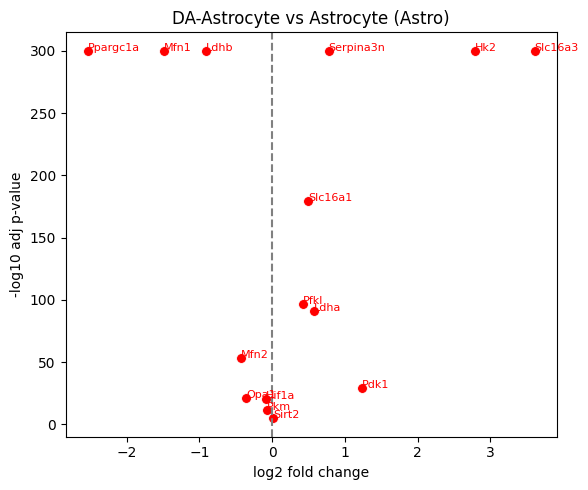

names     scores  logfoldchanges          pvals      pvals_adj
0     Slc16a3  40.217354        3.609624   0.000000e+00   0.000000e+00
1         Hk2  68.022560        2.795144   0.000000e+00   0.000000e+00
2        Pdk1  11.411472        1.230986   3.664751e-30   1.273426e-29
3   Serpina3n  64.491745        0.775744   0.000000e+00   0.000000e+00
4        Ldha  20.408680        0.570317   1.400127e-92   8.024771e-92
5     Slc16a1  28.666393        0.499491  1.001539e-180  8.416557e-180
6        Pfkl  20.991964        0.426422   7.766950e-98   4.585557e-97
7       Sirt2  -4.538477        0.016669   5.666187e-06   1.152842e-05
8         Pkm  -7.215299       -0.071088   5.381563e-13   1.381548e-12
9       Hif1a  -9.483004       -0.082623   2.470674e-21   7.537625e-21
10       Opa1  -9.783880       -0.354795   1.320482e-22   4.114709e-22
11       Mfn2 -15.534849       -0.429378   2.015463e-54   8.824786e-54
12       Ldhb -91.312134       -0.911794   0.000000e+00   0.000000e+00
13       Mfn1 -59.696293       -1.484914   0.000000e+00   0.000000e+00
14   Ppargc1a -44.948975       -2.532138   0.000000e+00   0.000000e+00

In [73]:
deg_ast = deg_two_groups_by_pattern(
    adata,
    pattern="Astro",
    reference="Astrocyte",
    target="DA-Astrocyte",
    genes=genes,      # highlight your metabolic gene set
    method="wilcoxon",
    use_raw=False, 
)
deg_ast

/Users/christoffer/miniconda3/envs/sc/lib/python3.8/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


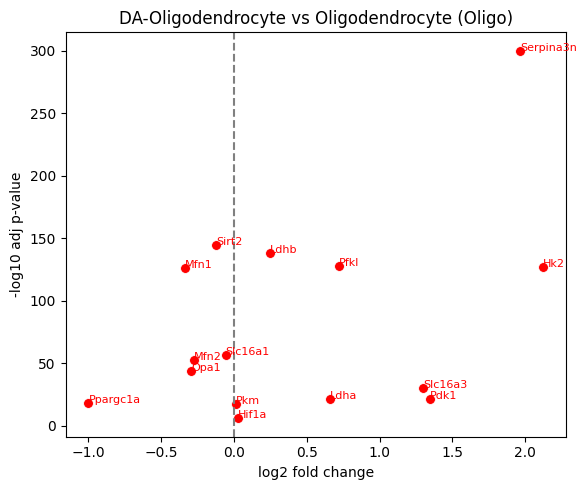

names     scores  logfoldchanges          pvals      pvals_adj
0     Slc16a3  40.217354        3.609624   0.000000e+00   0.000000e+00
1         Hk2  68.022560        2.795144   0.000000e+00   0.000000e+00
2        Pdk1  11.411472        1.230986   3.664751e-30   1.273426e-29
3   Serpina3n  64.491745        0.775744   0.000000e+00   0.000000e+00
4        Ldha  20.408680        0.570317   1.400127e-92   8.024771e-92
5     Slc16a1  28.666393        0.499491  1.001539e-180  8.416557e-180
6        Pfkl  20.991964        0.426422   7.766950e-98   4.585557e-97
7       Sirt2  -4.538477        0.016669   5.666187e-06   1.152842e-05
8         Pkm  -7.215299       -0.071088   5.381563e-13   1.381548e-12
9       Hif1a  -9.483004       -0.082623   2.470674e-21   7.537625e-21
10       Opa1  -9.783880       -0.354795   1.320482e-22   4.114709e-22
11       Mfn2 -15.534849       -0.429378   2.015463e-54   8.824786e-54
12       Ldhb -91.312134       -0.911794   0.000000e+00   0.000000e+00
13       Mfn1 -59.696293       -1.484914   0.000000e+00   0.000000e+00
14   Ppargc1a -44.948975       -2.532138   0.000000e+00   0.000000e+00

In [74]:
deg_ol = deg_two_groups_by_pattern(
    adata,
    pattern="Oligo",
    reference="Oligodendrocyte",
    target="DA-Oligodendrocyte",
    genes=genes,      # highlight your metabolic gene set
    method="wilcoxon",
    use_raw=False, 
)
deg_ast

/Users/christoffer/miniconda3/envs/sc/lib/python3.8/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


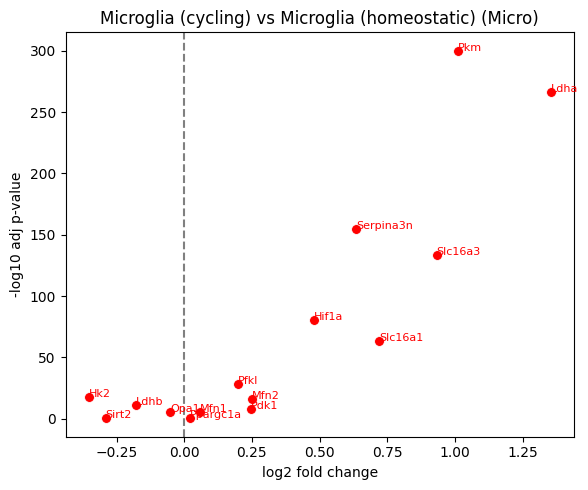

names     scores  logfoldchanges          pvals      pvals_adj
0     Slc16a3  40.217354        3.609624   0.000000e+00   0.000000e+00
1         Hk2  68.022560        2.795144   0.000000e+00   0.000000e+00
2        Pdk1  11.411472        1.230986   3.664751e-30   1.273426e-29
3   Serpina3n  64.491745        0.775744   0.000000e+00   0.000000e+00
4        Ldha  20.408680        0.570317   1.400127e-92   8.024771e-92
5     Slc16a1  28.666393        0.499491  1.001539e-180  8.416557e-180
6        Pfkl  20.991964        0.426422   7.766950e-98   4.585557e-97
7       Sirt2  -4.538477        0.016669   5.666187e-06   1.152842e-05
8         Pkm  -7.215299       -0.071088   5.381563e-13   1.381548e-12
9       Hif1a  -9.483004       -0.082623   2.470674e-21   7.537625e-21
10       Opa1  -9.783880       -0.354795   1.320482e-22   4.114709e-22
11       Mfn2 -15.534849       -0.429378   2.015463e-54   8.824786e-54
12       Ldhb -91.312134       -0.911794   0.000000e+00   0.000000e+00
13       Mfn1 -59.696293       -1.484914   0.000000e+00   0.000000e+00
14   Ppargc1a -44.948975       -2.532138   0.000000e+00   0.000000e+00

In [75]:
deg_micro_vs_cyc = deg_two_groups_by_pattern(
    adata,
    pattern="Micro",
    reference="Microglia (homeostatic)",
    target='Microglia (cycling)',
    genes=genes,      # highlight your metabolic gene set
    method="wilcoxon",
    use_raw=False, 
)
deg_ast

/Users/christoffer/miniconda3/envs/sc/lib/python3.8/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


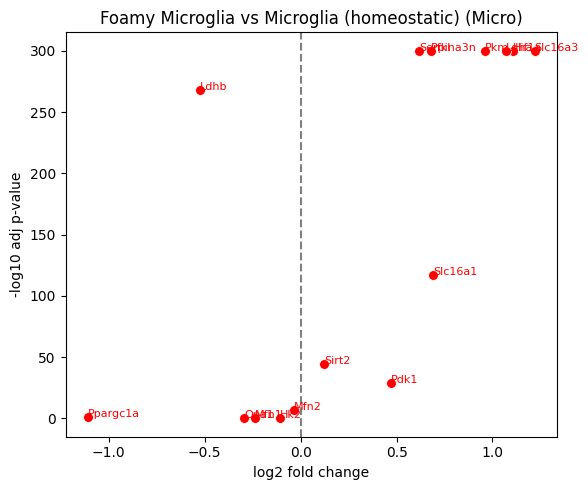

names     scores  logfoldchanges          pvals      pvals_adj
0     Slc16a3  40.217354        3.609624   0.000000e+00   0.000000e+00
1         Hk2  68.022560        2.795144   0.000000e+00   0.000000e+00
2        Pdk1  11.411472        1.230986   3.664751e-30   1.273426e-29
3   Serpina3n  64.491745        0.775744   0.000000e+00   0.000000e+00
4        Ldha  20.408680        0.570317   1.400127e-92   8.024771e-92
5     Slc16a1  28.666393        0.499491  1.001539e-180  8.416557e-180
6        Pfkl  20.991964        0.426422   7.766950e-98   4.585557e-97
7       Sirt2  -4.538477        0.016669   5.666187e-06   1.152842e-05
8         Pkm  -7.215299       -0.071088   5.381563e-13   1.381548e-12
9       Hif1a  -9.483004       -0.082623   2.470674e-21   7.537625e-21
10       Opa1  -9.783880       -0.354795   1.320482e-22   4.114709e-22
11       Mfn2 -15.534849       -0.429378   2.015463e-54   8.824786e-54
12       Ldhb -91.312134       -0.911794   0.000000e+00   0.000000e+00
13       Mfn1 -59.696293       -1.484914   0.000000e+00   0.000000e+00
14   Ppargc1a -44.948975       -2.532138   0.000000e+00   0.000000e+00

In [76]:
deg_micro_vs_foamy = deg_two_groups_by_pattern(
    adata,
    pattern="Micro",
    reference="Microglia (homeostatic)",
    target='Foamy Microglia',
    genes=genes,      # highlight your metabolic gene set
    method="wilcoxon",
    use_raw=False, 
)
deg_ast

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import sparse

def plot_gene_expr_with_control_ref(
    adata,
    genes,
    groupby="sub_type_III",
    reference="Astrocyte",
    condition_col="condition",
    control_value="Control",
    target_condition=None,   # e.g. "EAE" or None
    celltype_pattern=None,   # e.g. "Astro"
    use_raw=True,
    layer=None,
    bins=50
):
    # ---- start from a copy and normalize index/labels to plain strings ----
    ad = adata.copy()
    ad.obs.index = pd.Index(ad.obs.index.astype(str), dtype=object)
    ad.obs[groupby] = ad.obs[groupby].astype(str)
    ad.obs[condition_col] = ad.obs[condition_col].astype(str)

    # optional pattern subset (e.g., keep only Astro*)
    if celltype_pattern is not None:
        mask_pat = ad.obs[groupby].str.contains(celltype_pattern, na=False)
        ad = ad[mask_pat].copy()

    # build masks (on current ad)
    cond_up = ad.obs[condition_col].str.upper()
    is_ref  = ad.obs[groupby] == reference
    is_ctrl = cond_up == str(control_value).upper()

    ref_mask = is_ref & is_ctrl           # reference-in-controls only
    nonref_mask = ~is_ref                  # all non-reference groups
    if target_condition is not None:
        nonref_mask &= (cond_up == str(target_condition).upper())

    keep_mask = ref_mask | nonref_mask
    if not keep_mask.any():
        raise ValueError("No cells after applying filters.")
    if not ref_mask.any():
        raise ValueError(f"No control cells for reference='{reference}' (condition={control_value}).")

    # subset and **recompute masks on the subset**
    ad = ad[keep_mask].copy()
    cond_up = ad.obs[condition_col].str.upper()
    is_ref  = ad.obs[groupby] == reference
    is_ctrl = cond_up == str(control_value).upper()
    ref_mask = is_ref & is_ctrl  # recomputed on subset

    # pick matrix for genes
    if use_raw:
        if ad.raw is None:
            raise ValueError("adata.raw is None; set use_raw=False or specify layer.")
        X = ad.raw[:, genes].X
    elif layer is not None:
        X = ad[:, genes].layers[layer]
    else:
        X = ad[:, genes].X
    if sparse.issparse(X):
        X = X.toarray()

    # tidy frame
    df = pd.DataFrame(X, columns=genes, index=ad.obs_names)
    labels = ad.obs[groupby].astype(str).copy()

    # relabel reference rows (on the subset-aligned mask)
    ref_label = f"{reference} (Control only)"
    labels.loc[labels.index[ref_mask.values]] = ref_label

    if target_condition is not None:
        # annotate non-reference with target condition
        nonref_idx = labels.index[~ref_mask.values]
        labels.loc[nonref_idx] = labels.loc[nonref_idx] + f" ({target_condition})"

    df[groupby] = pd.Series(labels.values, index=df.index, dtype=object)

        # --- fixed, consistent colors ---
    groups = list(pd.unique(df[groupby]))  # preserve order as in df
    palette = sns.color_palette("tab10", n_colors=len(groups))
    palmap = {g: c for g, c in zip(groups, palette)}
    
    for gene in genes:
        plt.figure(figsize=(6,4))
        ax = sns.histplot(
            data=df, x=gene, hue=groupby,
            hue_order=groups, palette=palmap,  # <-- lock order & colors
            element="step", stat="density", common_norm=False, bins=bins,
            alpha=0.35, edgecolor=None
        )
    
        # group means with EXACT same colors
        means = df.groupby(groupby, dropna=False)[gene].mean()
        for g in groups:
            mu = means.get(g, np.nan)
            if np.isfinite(mu):
                ax.axvline(mu, color=palmap[g], linestyle="--", linewidth=1.8,
                           label=f"{g} μ={mu:.2f}")
    
        plt.title(f"{gene} expression (ref = {reference} in {control_value})")
        plt.xlabel("log1p normalized expression" if use_raw else "expression")
        plt.ylabel("Density")
    
        # clean legend (dedupe)
        handles, labels = ax.get_legend_handles_labels()
        seen, H, L = set(), [], []
        for h, l in zip(handles, labels):
            if l not in seen:
                seen.add(l); H.append(h); L.append(l)
        plt.legend(H, L, fontsize=8, loc="best", frameon=True)
        plt.tight_layout()
        plt.show()

    return df

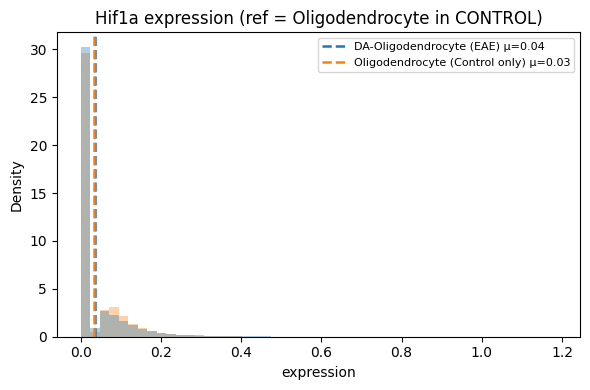

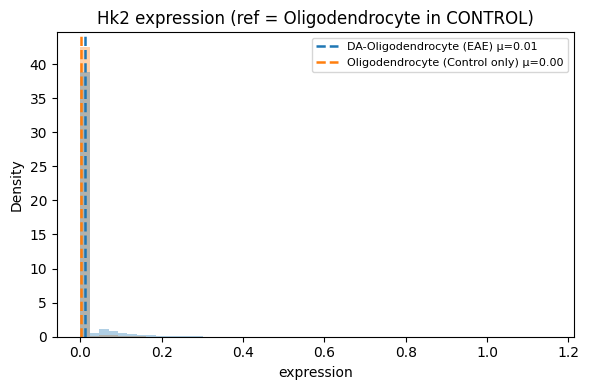

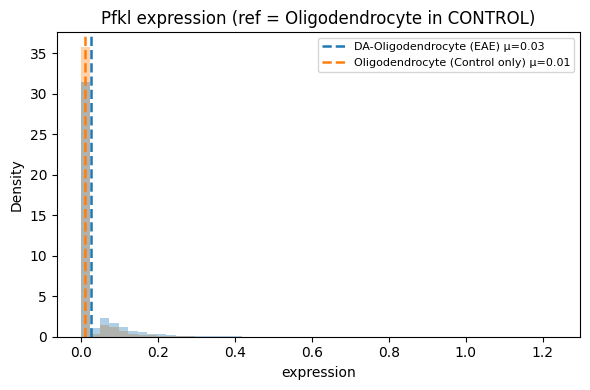

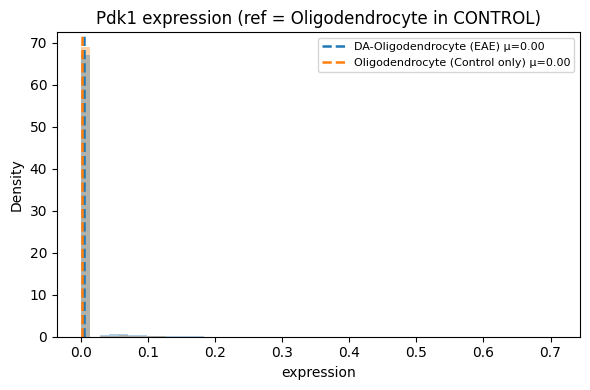

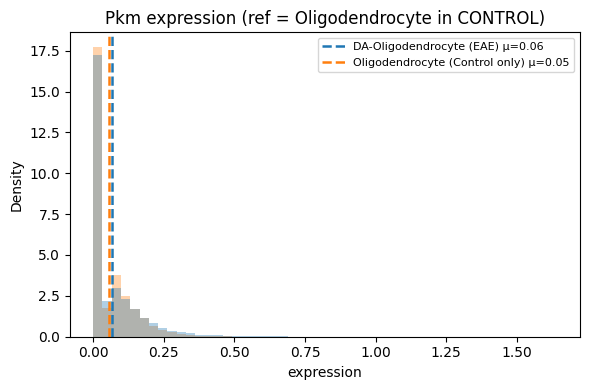

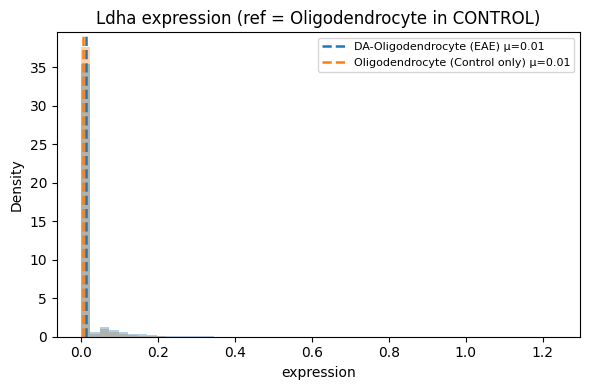

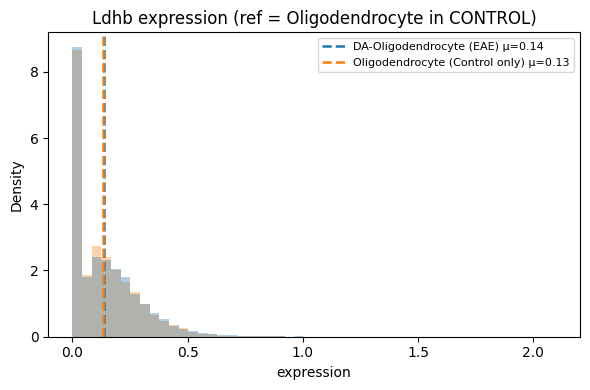

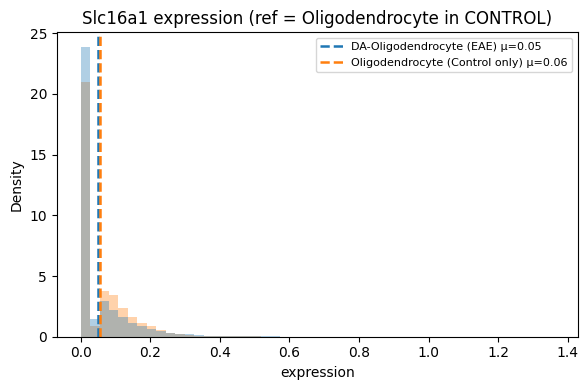

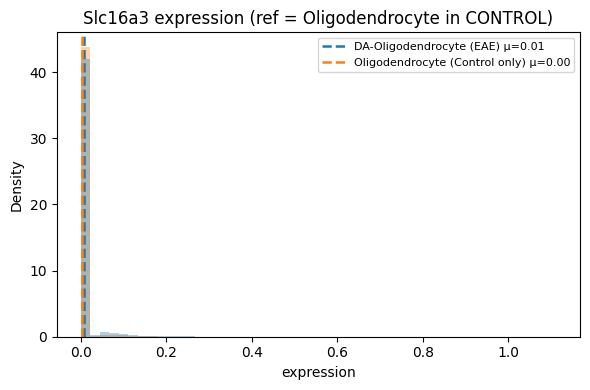

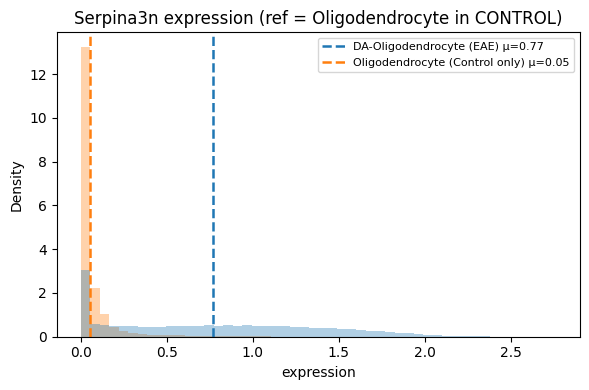

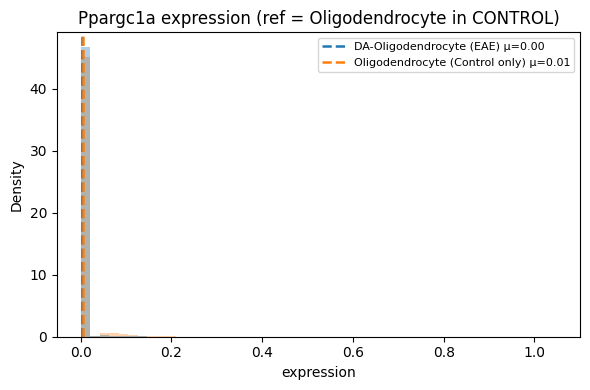

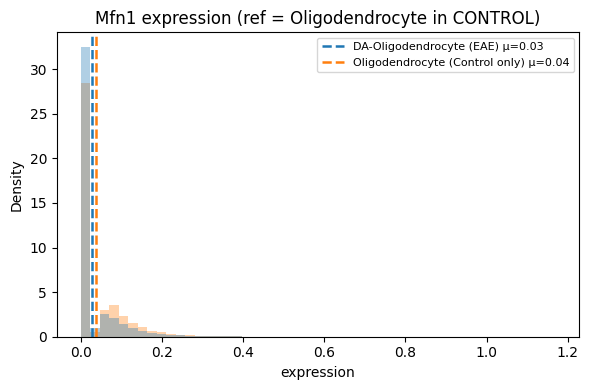

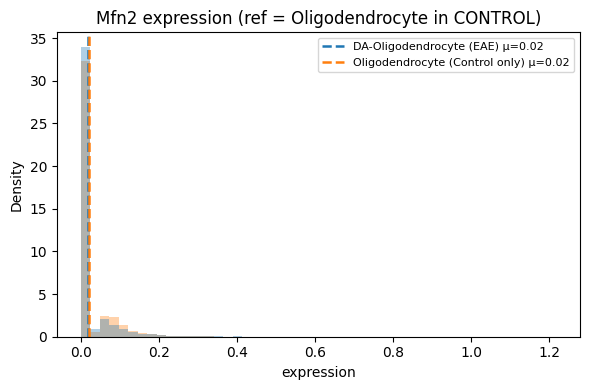

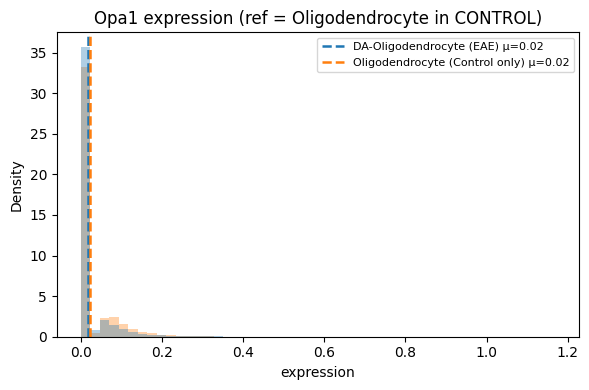

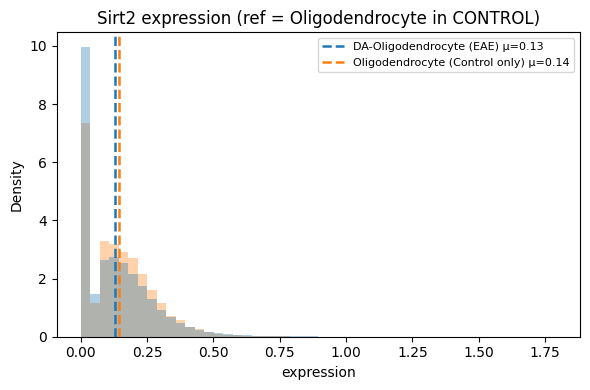

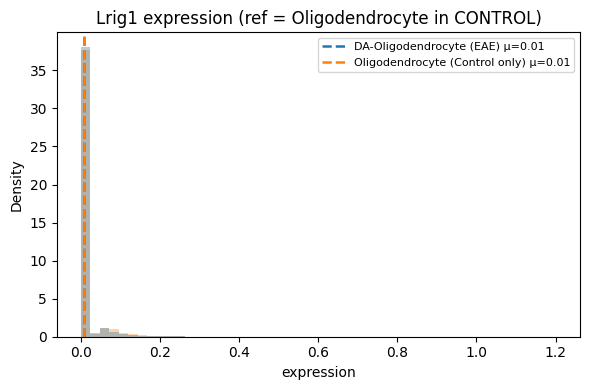

In [34]:

_ = plot_gene_expr_with_control_ref(
    adata,
    genes=genes,
    groupby="sub_type_III",
    reference="Oligodendrocyte",          # baseline cluster
    condition_col="condition",       # e.g., "condition" ∈ {"Control","EAE"}
    control_value="CONTROL",         # take reference from Control only
    target_condition="EAE",          # (optional) restrict non-reference groups to EAE
    celltype_pattern="Oligo",        # keep only astro rows
    use_raw=False,                     # assumes adata.raw = log1p normalized
    bins=50,
)

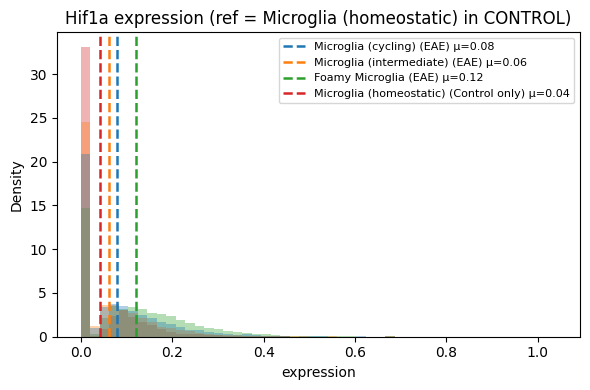

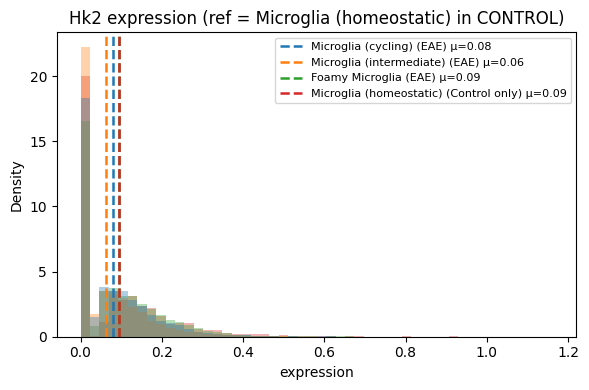

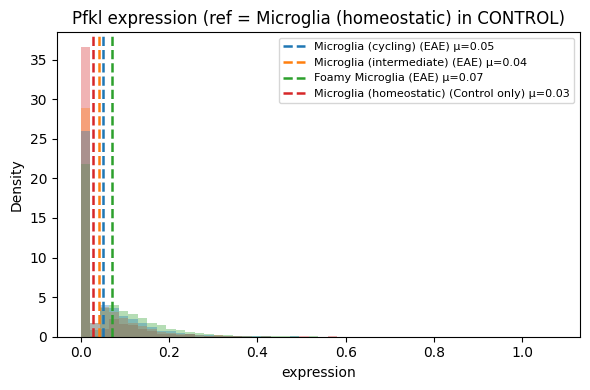

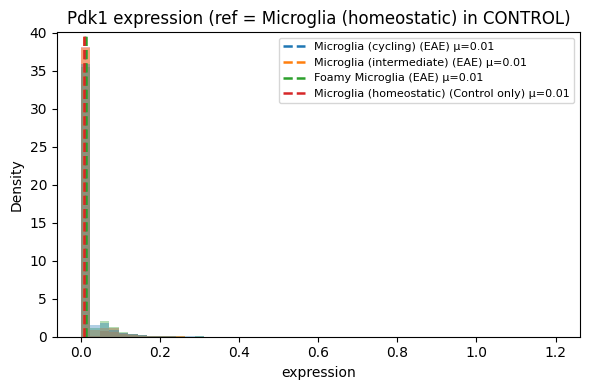

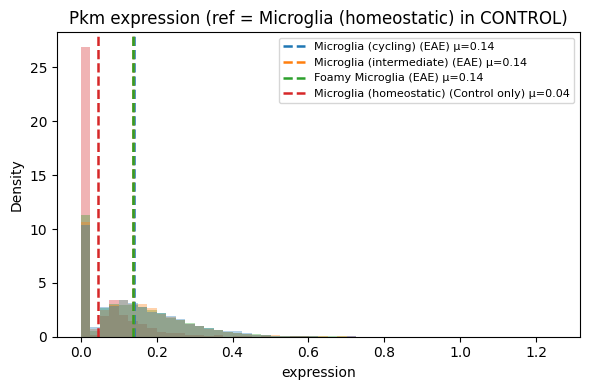

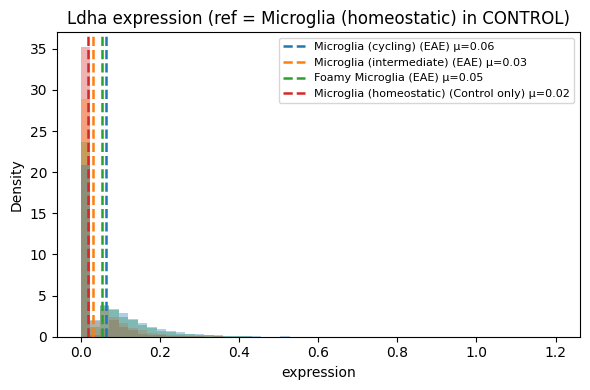

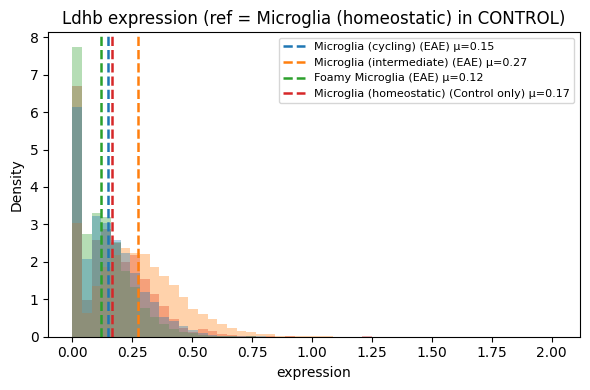

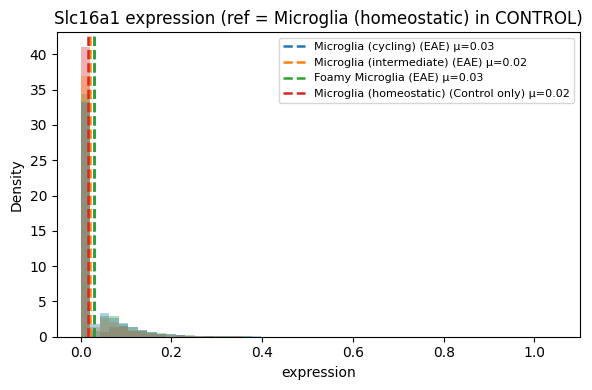

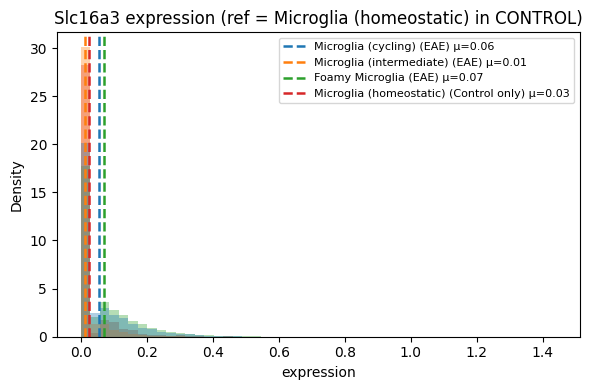

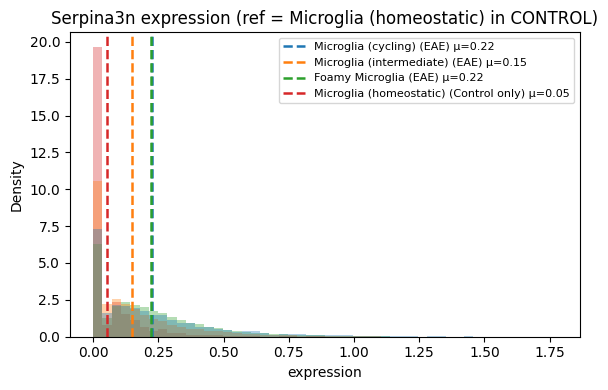

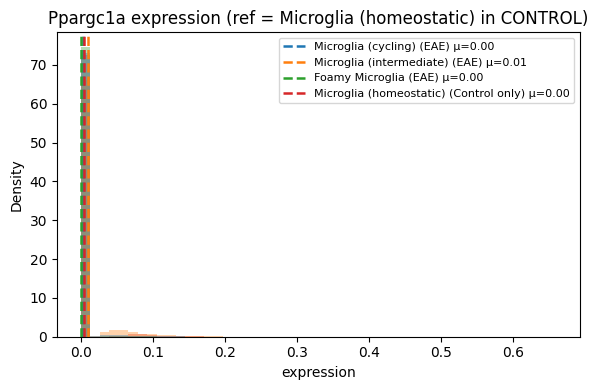

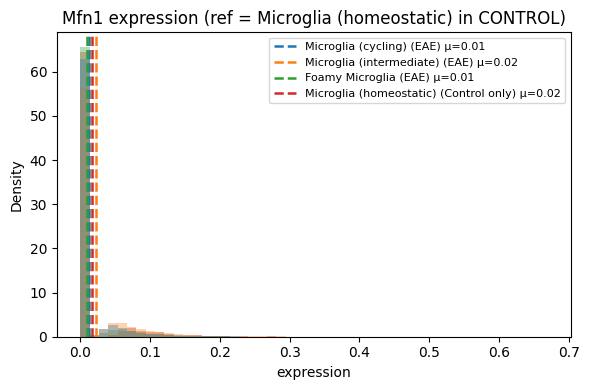

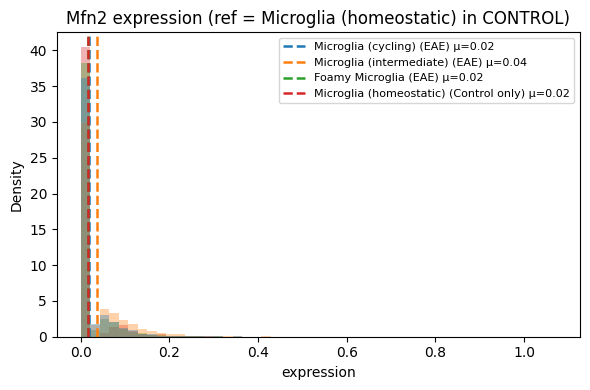

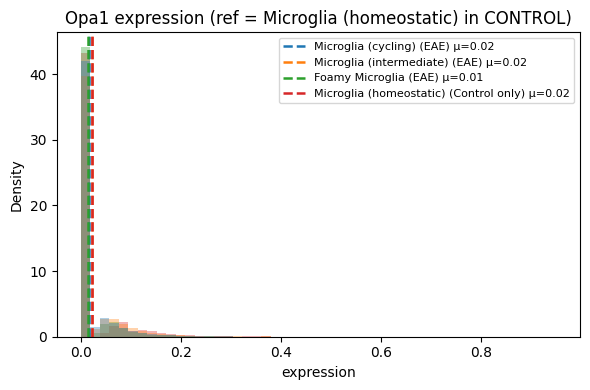

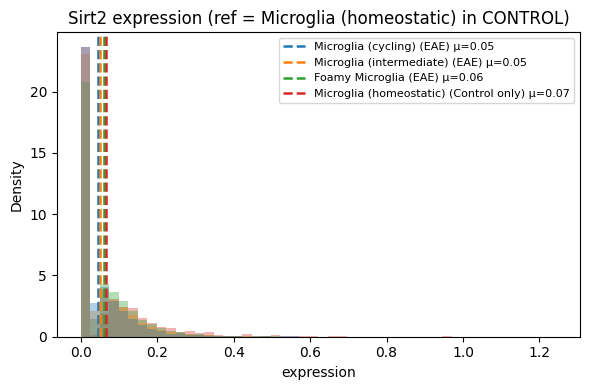

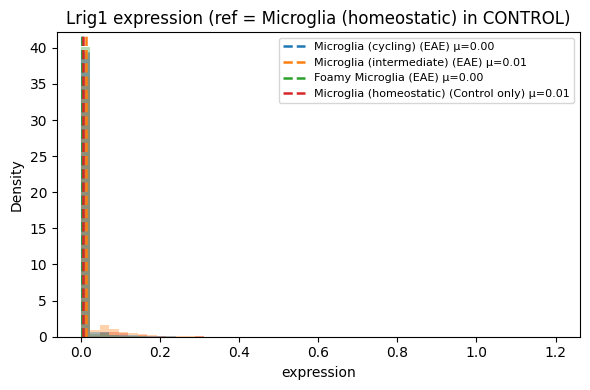

In [35]:

_ = plot_gene_expr_with_control_ref(
    adata,
    genes=genes,
    groupby="sub_type_III",
    reference="Microglia (homeostatic)",          # baseline cluster
    condition_col="condition",       # e.g., "condition" ∈ {"Control","EAE"}
    control_value="CONTROL",         # take reference from Control only
    target_condition="EAE",          # (optional) restrict non-reference groups to EAE
    celltype_pattern="Micro",        # keep only astro rows
    use_raw=False,                     # assumes adata.raw = log1p normalized
    bins=50,
)

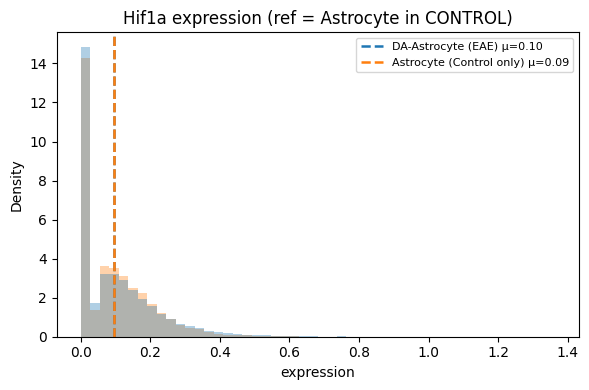

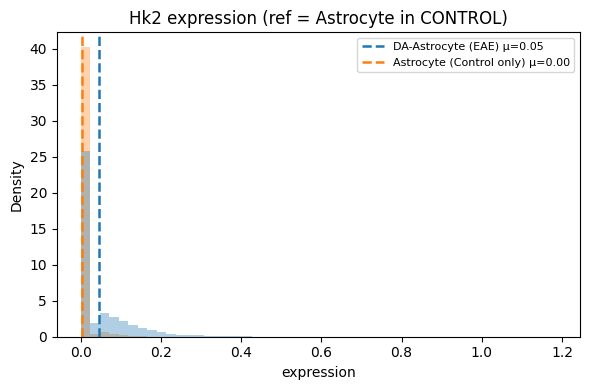

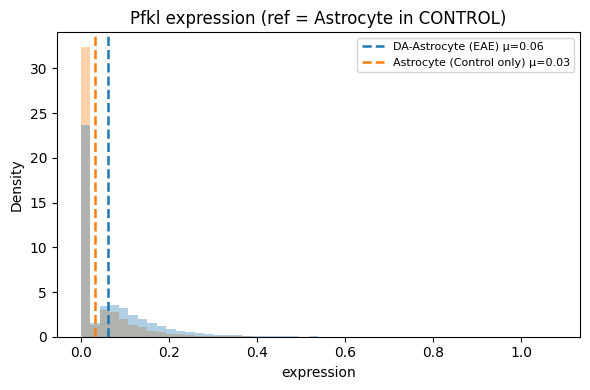

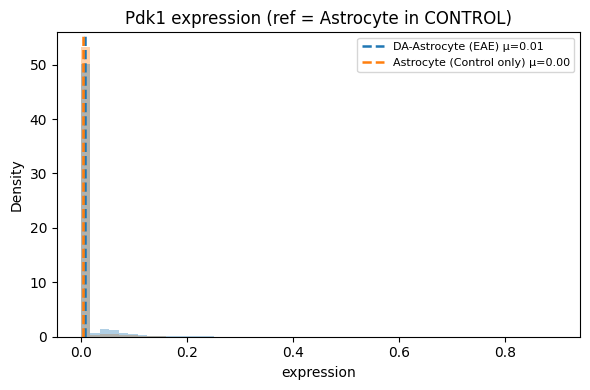

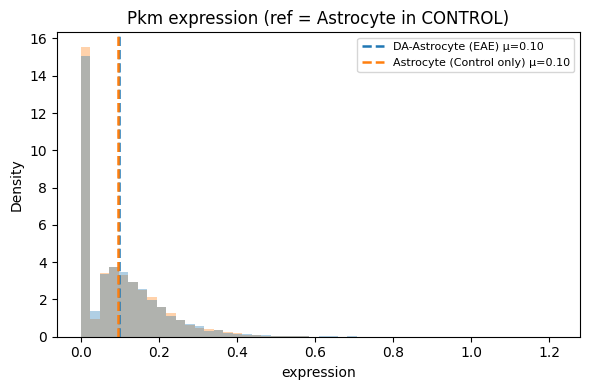

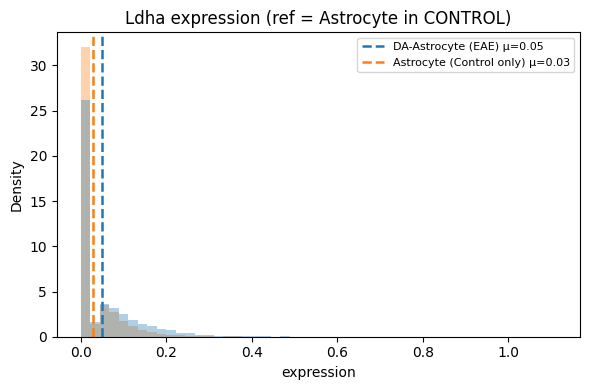

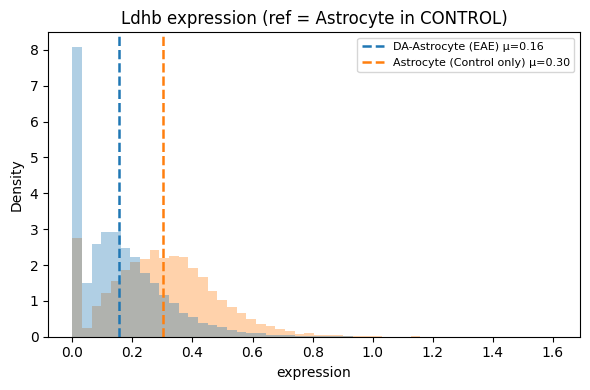

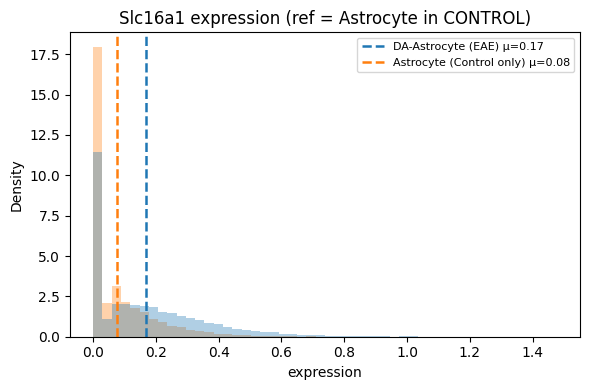

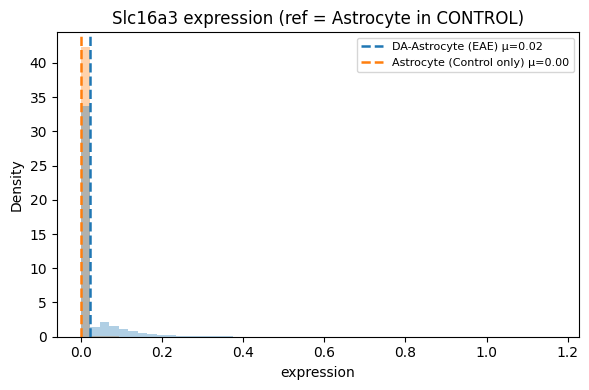

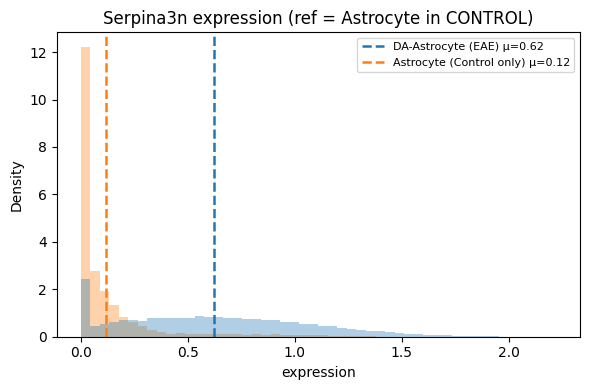

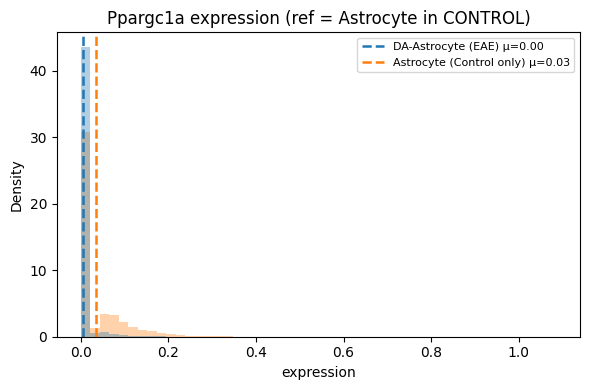

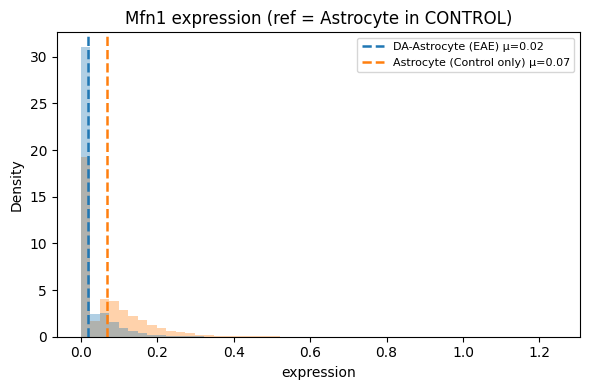

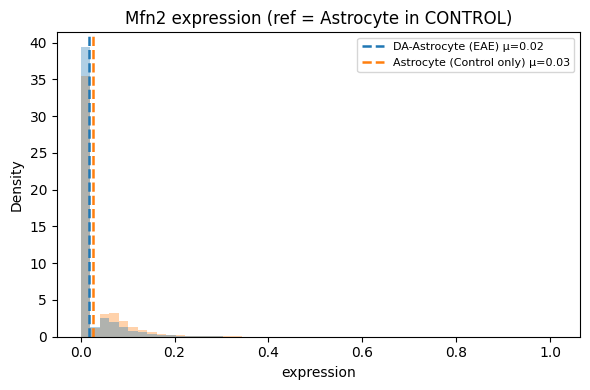

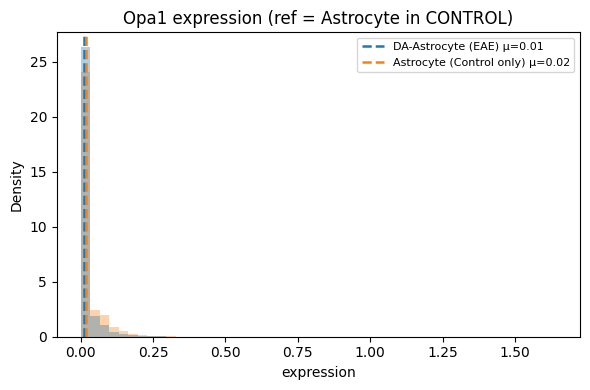

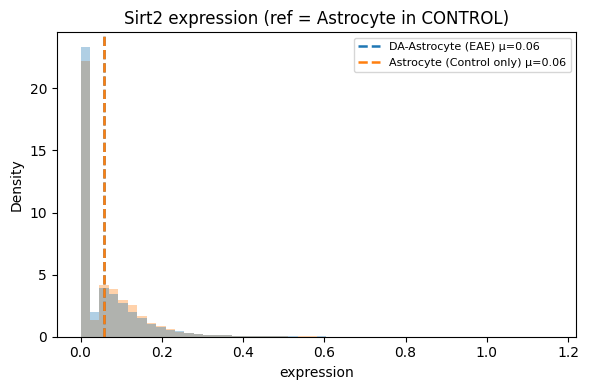

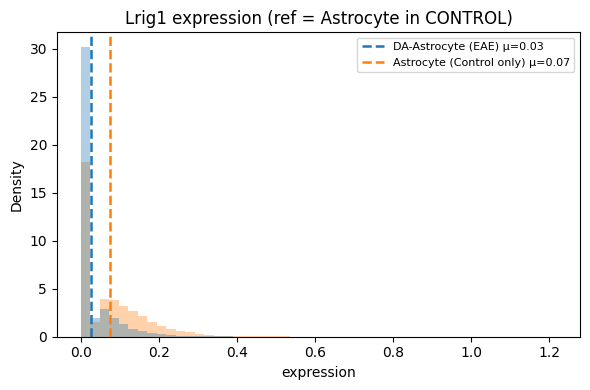

In [36]:

_ = plot_gene_expr_with_control_ref(
    adata,
    genes=genes,
    groupby="sub_type_III",
    reference="Astrocyte",          # baseline cluster
    condition_col="condition",       # e.g., "condition" ∈ {"Control","EAE"}
    control_value="CONTROL",         # take reference from Control only
    target_condition="EAE",          # (optional) restrict non-reference groups to EAE
    celltype_pattern="Astro",        # keep only astro rows
    use_raw=False,                     # assumes adata.raw = log1p normalized
    bins=50,
)

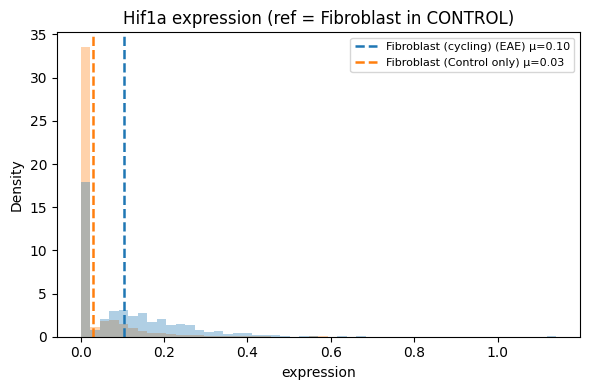

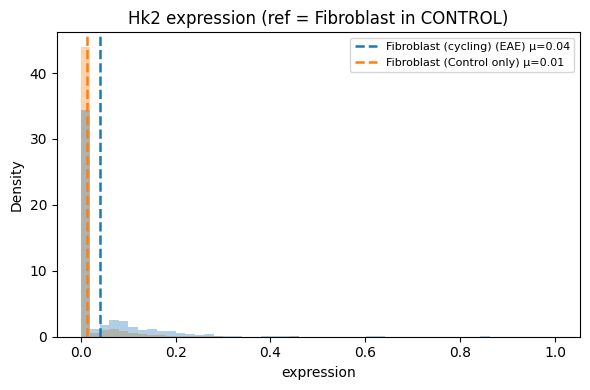

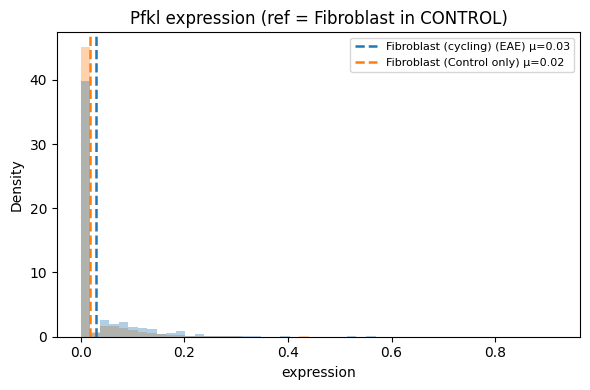

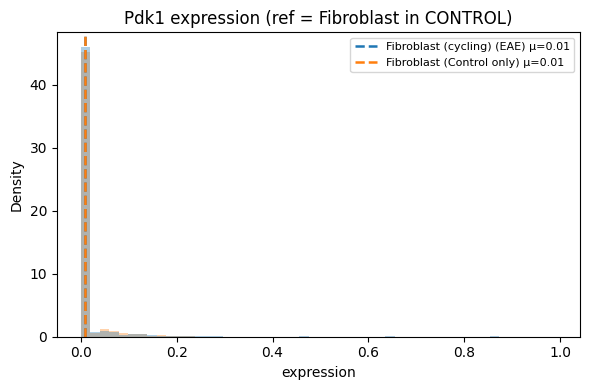

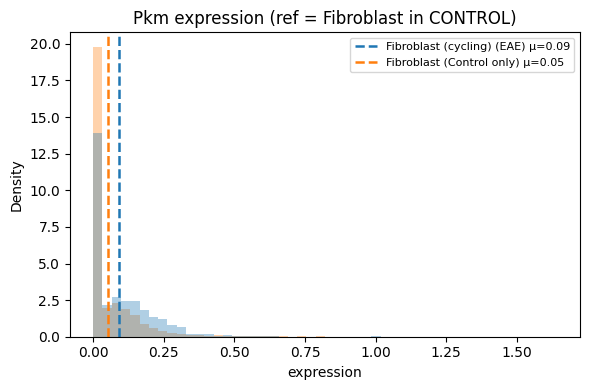

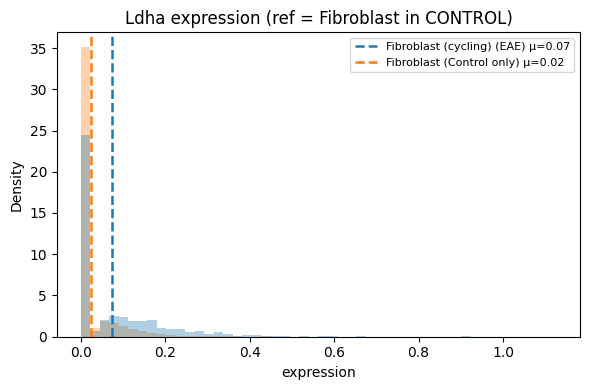

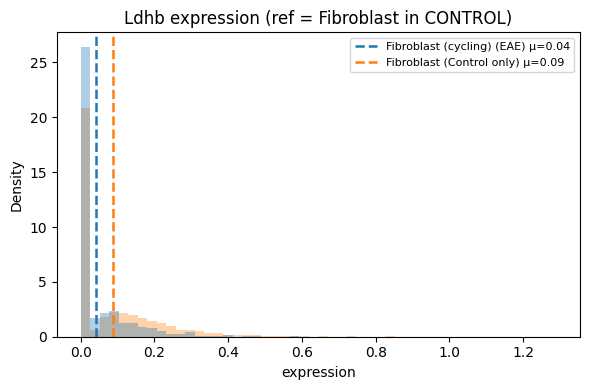

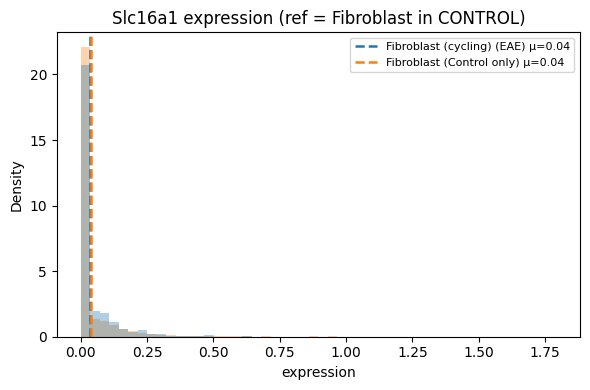

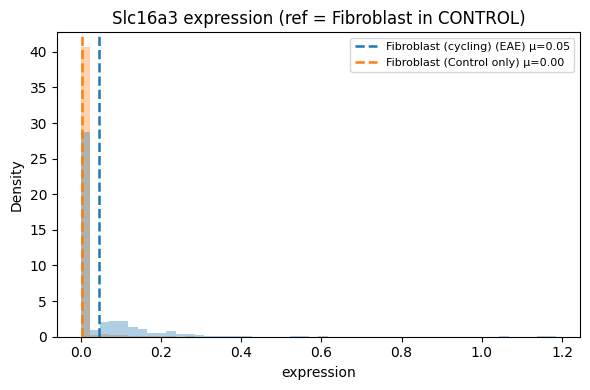

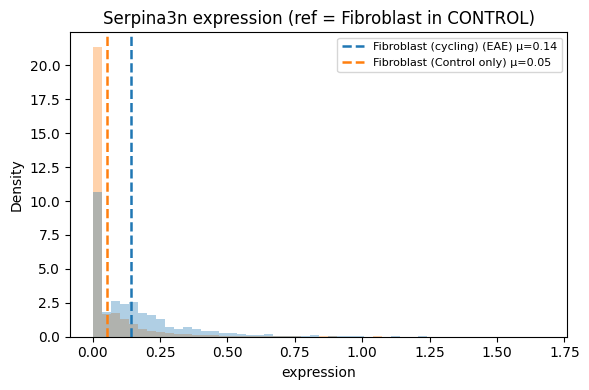

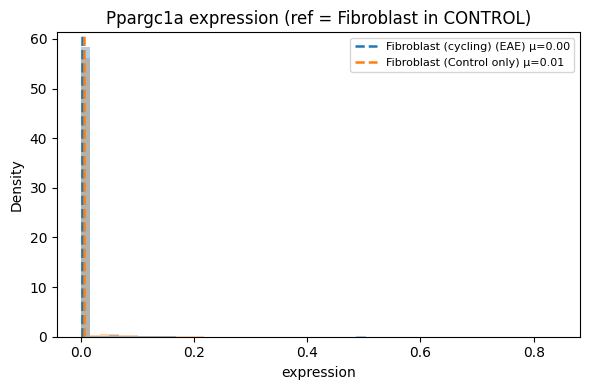

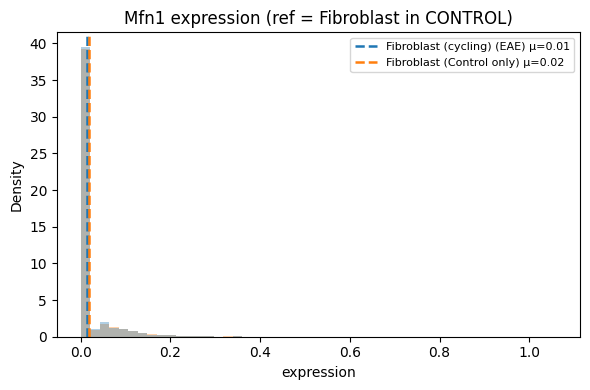

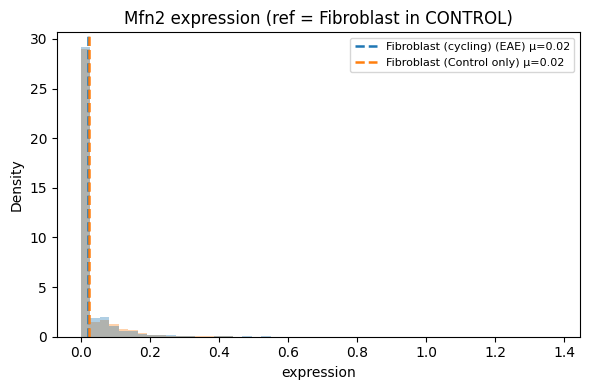

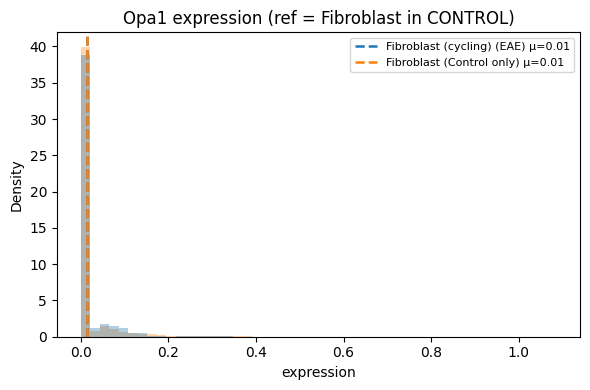

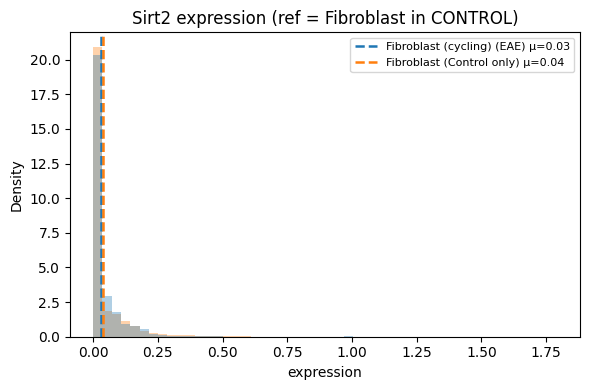

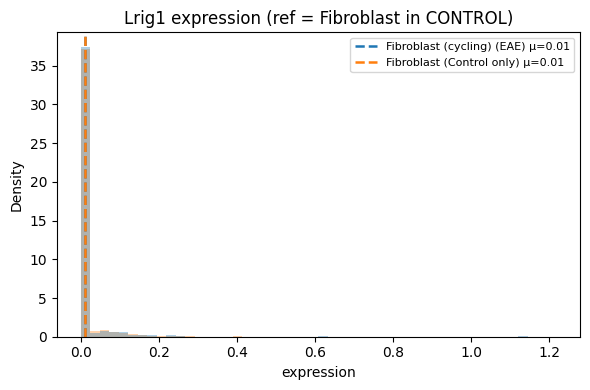

In [37]:

_ = plot_gene_expr_with_control_ref(
    adata,
    genes=genes,
    groupby="sub_type_III",
    reference="Fibroblast",          # baseline cluster
    condition_col="condition",       # e.g., "condition" ∈ {"Control","EAE"}
    control_value="CONTROL",         # take reference from Control only
    target_condition="EAE",          # (optional) restrict non-reference groups to EAE
    celltype_pattern="Fibro",        # keep only astro rows
    use_raw=False,                     # assumes adata.raw = log1p normalized
    bins=50,
)

In [125]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import sparse

def plot_gene_expr_with_control_ref_and_fc(
    adata,
    genes,
    groupby="sub_type_III",
    reference="Astrocyte",
    condition_col="condition",
    control_value="Control",
    target_condition=None,      # e.g. "EAE"; None = all non-ref conditions
    celltype_pattern=None,      # e.g. "Astro"
    use_raw=True,
    layer=None,
    bins=50,
    eps=1e-9
):
    # ---- prep AnnData subset ----
    ad = adata.copy()
    ad.obs.index = pd.Index(ad.obs.index.astype(str), dtype=object)
    ad.obs[groupby] = ad.obs[groupby].astype(str)
    ad.obs[condition_col] = ad.obs[condition_col].astype(str)

    if celltype_pattern is not None:
        ad = ad[ad.obs[groupby].str.contains(celltype_pattern, na=False)].copy()

    cond_up = ad.obs[condition_col].str.upper()
    is_ref  = ad.obs[groupby] == reference
    is_ctrl = cond_up == str(control_value).upper()

    ref_mask     = is_ref & is_ctrl
    nonref_mask  = ~is_ref
    if target_condition is not None:
        nonref_mask &= (cond_up == str(target_condition).upper())

    keep_mask = ref_mask | nonref_mask
    if not keep_mask.any(): raise ValueError("No cells after filters.")
    if not ref_mask.any():  raise ValueError(f"No control cells for '{reference}'.")

    ad = ad[keep_mask].copy()
    # recompute on subset
    cond_up = ad.obs[condition_col].str.upper()
    is_ref  = ad.obs[groupby] == reference
    is_ctrl = cond_up == str(control_value).upper()
    ref_mask = is_ref & is_ctrl

    # pick matrix
    if use_raw:
        if ad.raw is None:
            raise ValueError("adata.raw is None; set use_raw=False or provide a layer.")
        X = ad.raw[:, genes].X
    elif layer is not None:
        X = ad[:, genes].layers[layer]
    else:
        X = ad[:, genes].X
    if sparse.issparse(X): X = X.toarray()

    df = pd.DataFrame(X, columns=genes, index=ad.obs_names)
    labels = ad.obs[groupby].astype(str).copy()
    ref_label = f"{reference} (Control only)"
    labels.loc[labels.index[ref_mask.values]] = ref_label
    if target_condition is not None:
        nonref_idx = labels.index[~ref_mask.values]
        labels.loc[nonref_idx] = labels.loc[nonref_idx] + f" ({target_condition})"
    df[groupby] = pd.Series(labels.values, index=df.index, dtype=object)

    # consistent colors
    groups = list(pd.unique(df[groupby]))
    palette = sns.color_palette("tab10", n_colors=len(groups))
    palmap  = {g:c for g,c in zip(groups, palette)}

    # compute control means once per gene
    ctrl_name = ref_label
    if ctrl_name not in groups:
        raise ValueError("Internal error: control label not found.")

    for gene in genes:
        # means per displayed group
        means = df.groupby(groupby, dropna=False)[gene].mean()

        # ----- Figure with two panels -----
        fig, axes = plt.subplots(1, 2, figsize=(10,4), gridspec_kw={"wspace":0.35})

        # (A) Histograms with mean lines
        ax = axes[0]
        sns.histplot(
            data=df, x=gene, hue=groupby,
            hue_order=groups, palette=palmap,
            element="step", stat="density", common_norm=False, bins=bins,
            alpha=0.35, edgecolor=None, ax=ax
        )
        for g in groups:
            mu = means.get(g, np.nan)
            if np.isfinite(mu):
                ax.axvline(mu, color=palmap[g], linestyle="--", linewidth=1.8,
                           label=f"{g} μ={mu:.2f}")
        ax.set_title(f"{gene} expression (ref = {reference} in {control_value})")
        ax.set_xlabel("log1p normalized expression" if use_raw else "expression")
        ax.set_ylabel("Density")
        # tidy legend
        h,l = ax.get_legend_handles_labels()
        seen, H, L = set(), [], []
        for hh,ll in zip(h,l):
            if ll not in seen:
                seen.add(ll); H.append(hh); L.append(ll)
        ax.legend(H, L, fontsize=8, loc="best", frameon=True)

               # (B) log2FC bar(s) vs control (per non-ref group)
        ax2 = axes[1]
        fc_rows = []
        ctrl_mu = means.get(ctrl_name, np.nan)
        for g in groups:
            if g == ctrl_name: continue
            g_mu = means.get(g, np.nan)
            if np.isfinite(g_mu) and np.isfinite(ctrl_mu):
                fc_rows.append({"group": g, "log2FC": np.log2((g_mu+eps)/(ctrl_mu+eps))})
        
        if fc_rows:
            df_fc = pd.DataFrame(fc_rows)
            sns.barplot(data=df_fc, x="group", y="log2FC",
                        order=df_fc["group"],
                        palette=[palmap[g] for g in df_fc["group"]],
                        ax=ax2)
            ax2.axhline(0, color="gray", lw=1)
            ax2.set_ylabel("log2FC (mean vs control)")
            ax2.set_xlabel("")
            ax2.set_title(f"{gene}: log2FC vs control")
            ax2.tick_params(axis='x', rotation=45)
            for tick in ax2.get_xticklabels():
                tick.set_ha('right')
        else:
            ax2.text(0.5, 0.5, "No non-reference groups", ha="center", va="center")
            ax2.axis("off")

        plt.tight_layout()
        plt.show()

    return df

/var/folders/pm/2253tbm54v36j0l7lhshq73r0000gn/T/ipykernel_7114/1923675709.py:123: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_fc, x="group", y="log2FC",
/var/folders/pm/2253tbm54v36j0l7lhshq73r0000gn/T/ipykernel_7114/1923675709.py:138: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


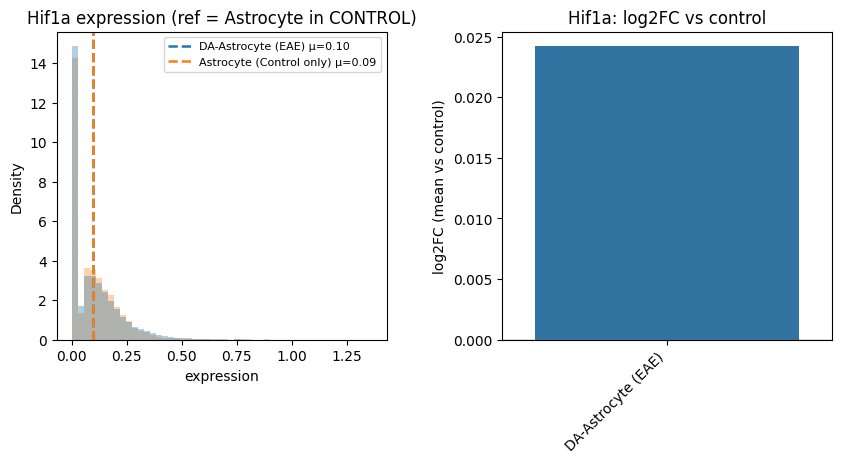

/var/folders/pm/2253tbm54v36j0l7lhshq73r0000gn/T/ipykernel_7114/1923675709.py:123: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_fc, x="group", y="log2FC",
/var/folders/pm/2253tbm54v36j0l7lhshq73r0000gn/T/ipykernel_7114/1923675709.py:138: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


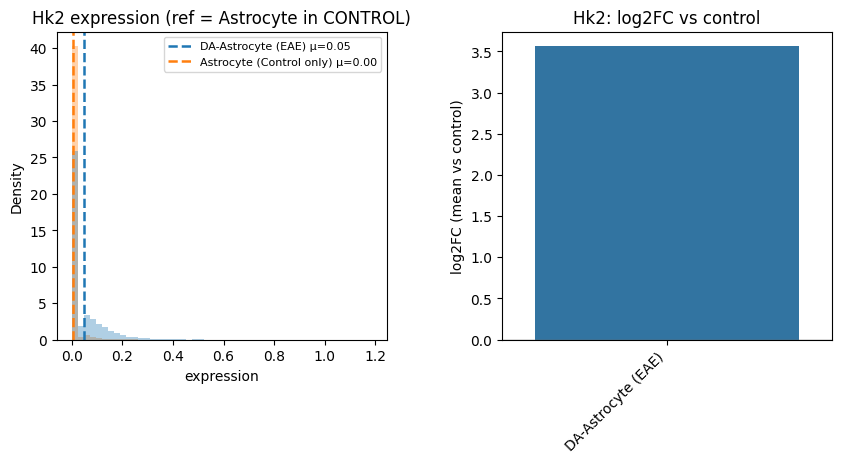

/var/folders/pm/2253tbm54v36j0l7lhshq73r0000gn/T/ipykernel_7114/1923675709.py:123: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_fc, x="group", y="log2FC",
/var/folders/pm/2253tbm54v36j0l7lhshq73r0000gn/T/ipykernel_7114/1923675709.py:138: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


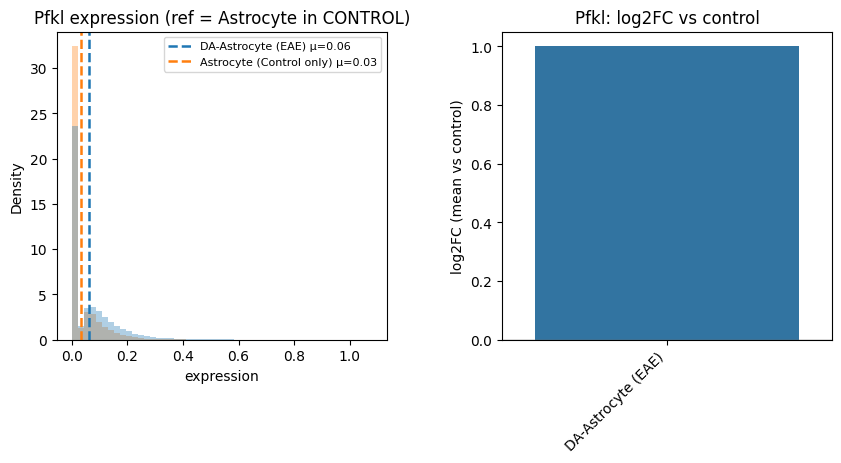

/var/folders/pm/2253tbm54v36j0l7lhshq73r0000gn/T/ipykernel_7114/1923675709.py:123: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_fc, x="group", y="log2FC",
/var/folders/pm/2253tbm54v36j0l7lhshq73r0000gn/T/ipykernel_7114/1923675709.py:138: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


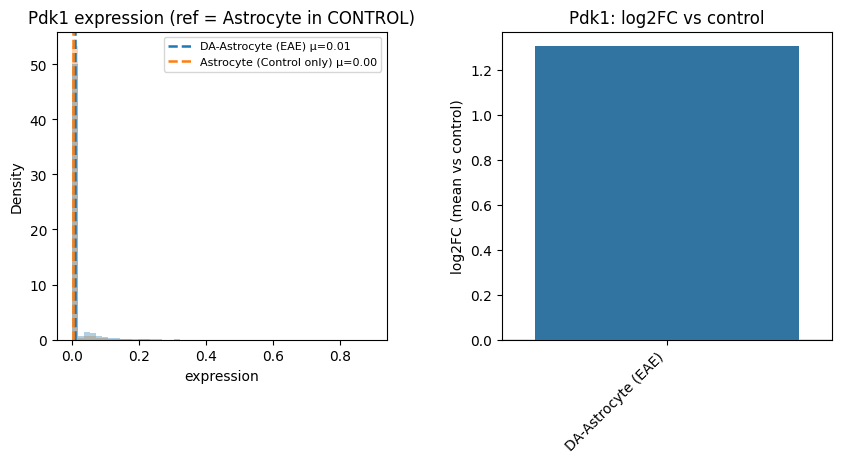

/var/folders/pm/2253tbm54v36j0l7lhshq73r0000gn/T/ipykernel_7114/1923675709.py:123: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_fc, x="group", y="log2FC",
/var/folders/pm/2253tbm54v36j0l7lhshq73r0000gn/T/ipykernel_7114/1923675709.py:138: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


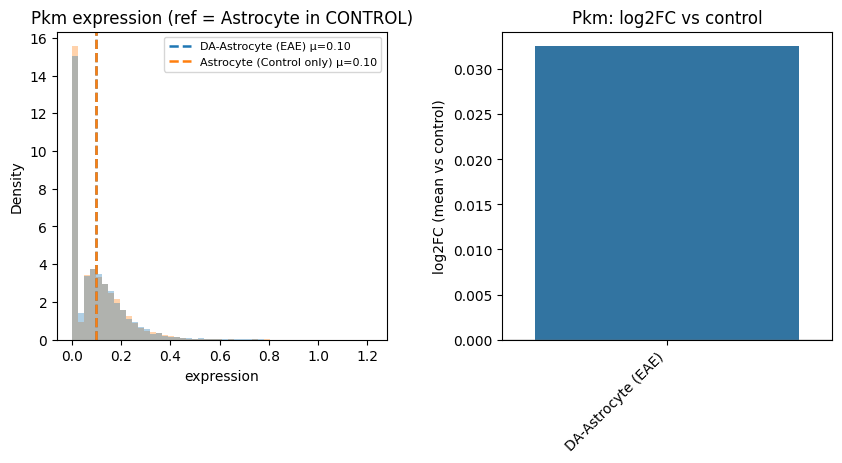

/var/folders/pm/2253tbm54v36j0l7lhshq73r0000gn/T/ipykernel_7114/1923675709.py:123: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_fc, x="group", y="log2FC",
/var/folders/pm/2253tbm54v36j0l7lhshq73r0000gn/T/ipykernel_7114/1923675709.py:138: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


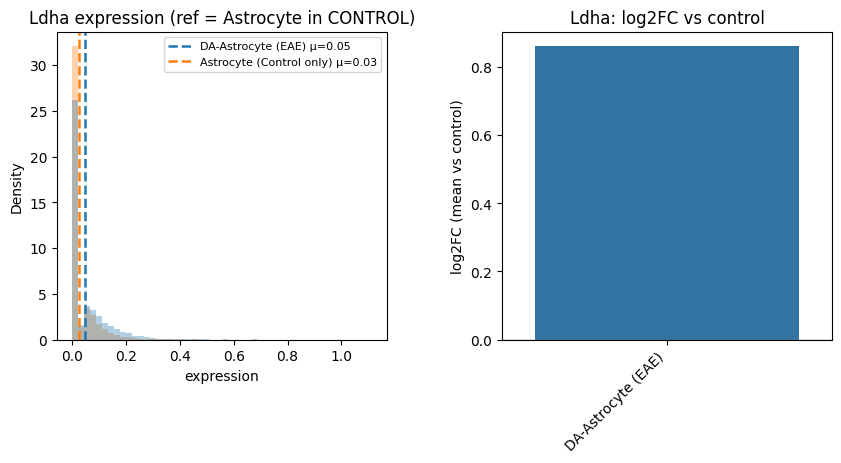

/var/folders/pm/2253tbm54v36j0l7lhshq73r0000gn/T/ipykernel_7114/1923675709.py:123: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_fc, x="group", y="log2FC",
/var/folders/pm/2253tbm54v36j0l7lhshq73r0000gn/T/ipykernel_7114/1923675709.py:138: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


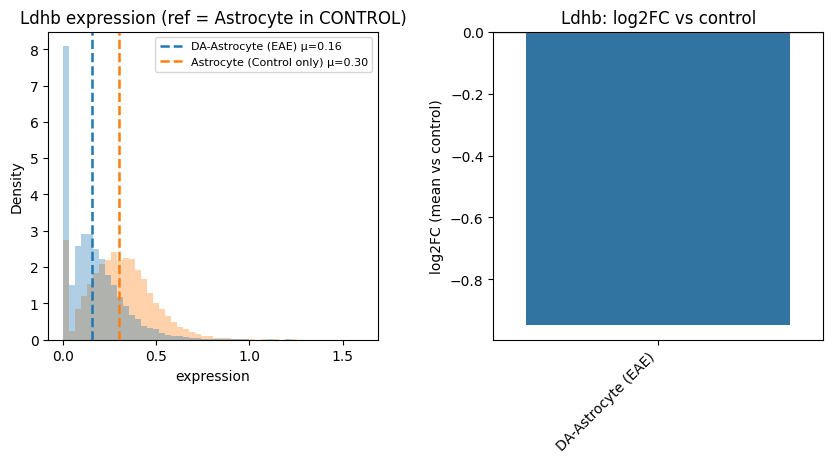

/var/folders/pm/2253tbm54v36j0l7lhshq73r0000gn/T/ipykernel_7114/1923675709.py:123: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_fc, x="group", y="log2FC",
/var/folders/pm/2253tbm54v36j0l7lhshq73r0000gn/T/ipykernel_7114/1923675709.py:138: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


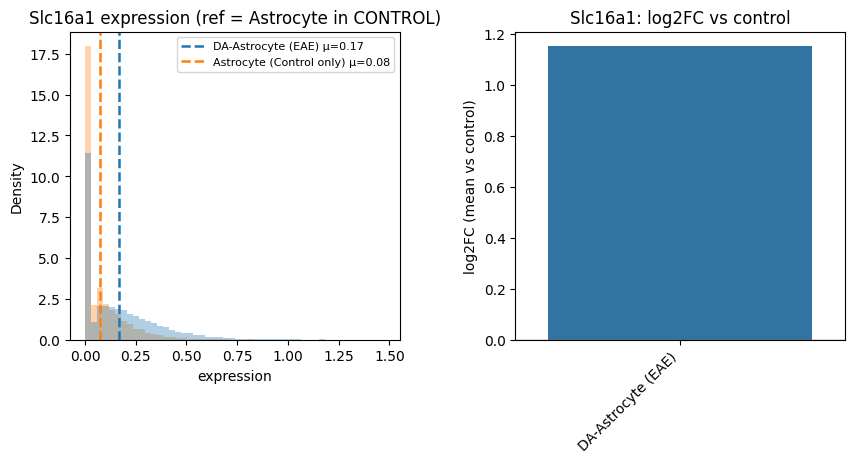

/var/folders/pm/2253tbm54v36j0l7lhshq73r0000gn/T/ipykernel_7114/1923675709.py:123: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_fc, x="group", y="log2FC",
/var/folders/pm/2253tbm54v36j0l7lhshq73r0000gn/T/ipykernel_7114/1923675709.py:138: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


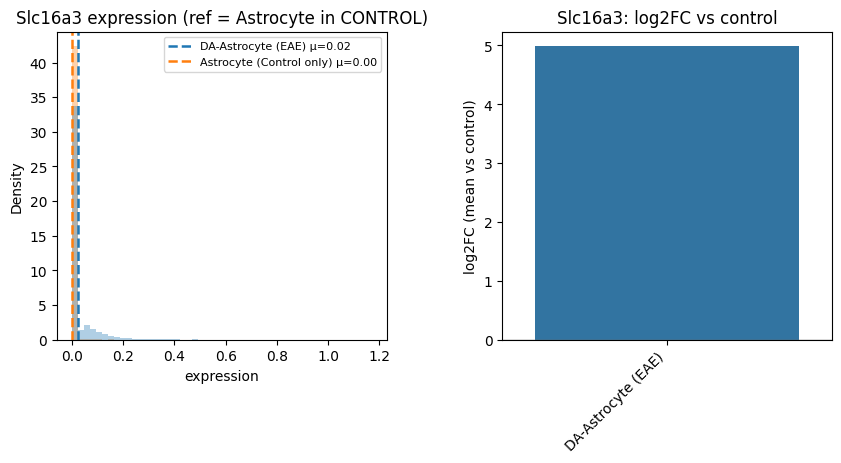

/var/folders/pm/2253tbm54v36j0l7lhshq73r0000gn/T/ipykernel_7114/1923675709.py:123: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_fc, x="group", y="log2FC",
/var/folders/pm/2253tbm54v36j0l7lhshq73r0000gn/T/ipykernel_7114/1923675709.py:138: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


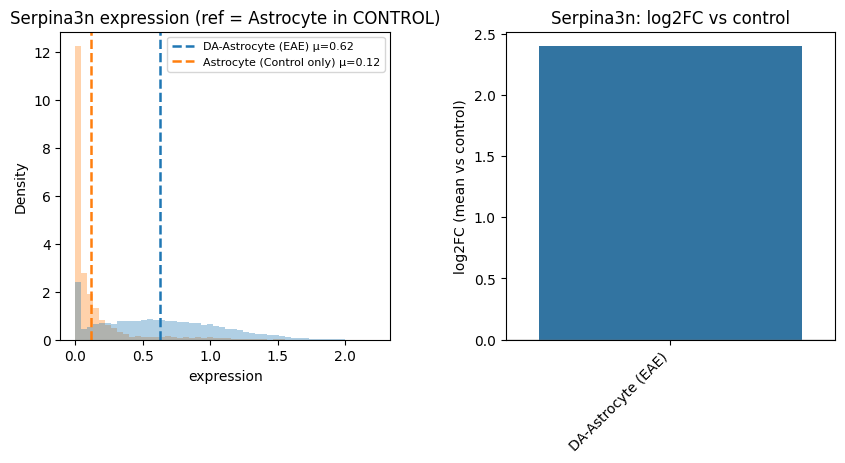

/var/folders/pm/2253tbm54v36j0l7lhshq73r0000gn/T/ipykernel_7114/1923675709.py:123: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_fc, x="group", y="log2FC",
/var/folders/pm/2253tbm54v36j0l7lhshq73r0000gn/T/ipykernel_7114/1923675709.py:138: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


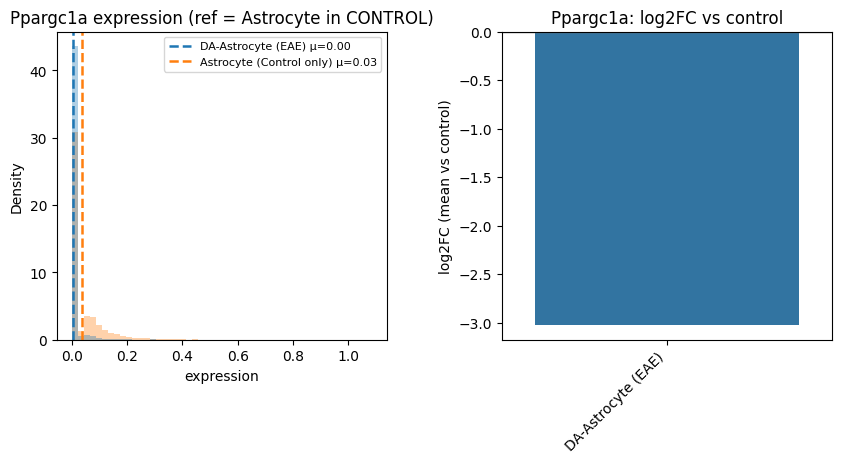

/var/folders/pm/2253tbm54v36j0l7lhshq73r0000gn/T/ipykernel_7114/1923675709.py:123: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_fc, x="group", y="log2FC",
/var/folders/pm/2253tbm54v36j0l7lhshq73r0000gn/T/ipykernel_7114/1923675709.py:138: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


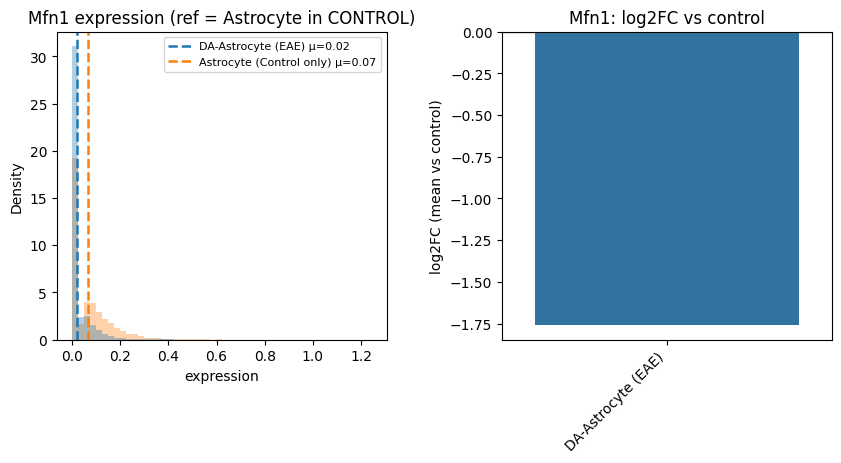

/var/folders/pm/2253tbm54v36j0l7lhshq73r0000gn/T/ipykernel_7114/1923675709.py:123: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_fc, x="group", y="log2FC",
/var/folders/pm/2253tbm54v36j0l7lhshq73r0000gn/T/ipykernel_7114/1923675709.py:138: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


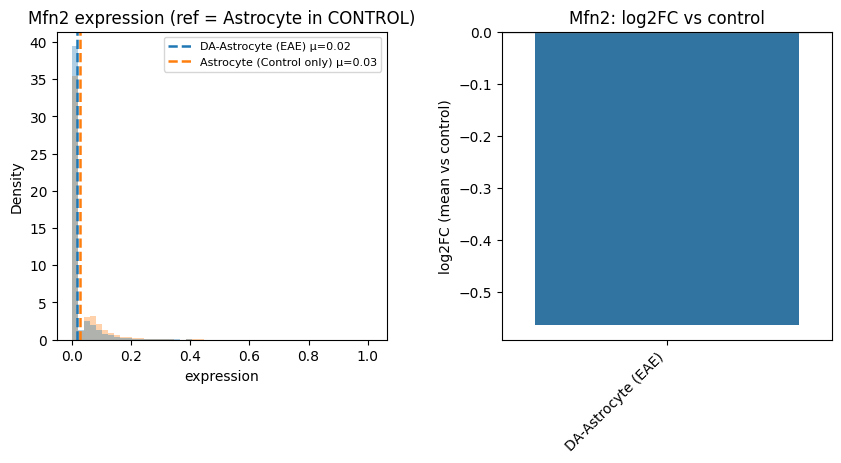

/var/folders/pm/2253tbm54v36j0l7lhshq73r0000gn/T/ipykernel_7114/1923675709.py:123: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_fc, x="group", y="log2FC",
/var/folders/pm/2253tbm54v36j0l7lhshq73r0000gn/T/ipykernel_7114/1923675709.py:138: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


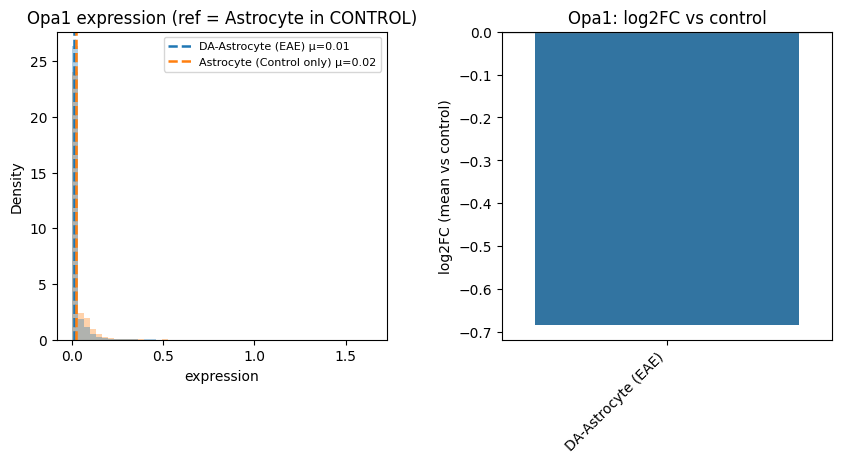

/var/folders/pm/2253tbm54v36j0l7lhshq73r0000gn/T/ipykernel_7114/1923675709.py:123: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_fc, x="group", y="log2FC",
/var/folders/pm/2253tbm54v36j0l7lhshq73r0000gn/T/ipykernel_7114/1923675709.py:138: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


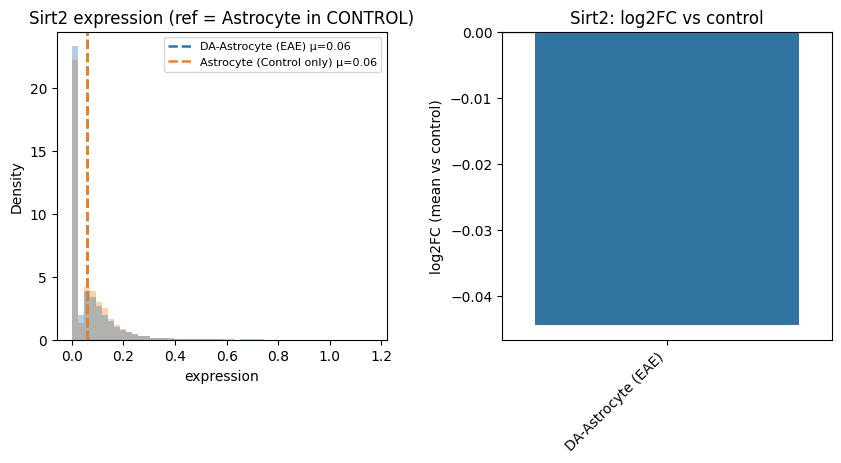

In [126]:

_ = plot_gene_expr_with_control_ref_and_fc(
    adata,
    genes=genes,
    groupby="sub_type_III",
    reference="Astrocyte",
    condition_col="condition",
    control_value="CONTROL",   # case-insensitive
    target_condition="EAE",    # only compare DA groups from disease
    celltype_pattern="Astro",
    use_raw=False               # or layer="log1p" with use_raw=False
)

/var/folders/pm/2253tbm54v36j0l7lhshq73r0000gn/T/ipykernel_7114/1923675709.py:123: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_fc, x="group", y="log2FC",
/var/folders/pm/2253tbm54v36j0l7lhshq73r0000gn/T/ipykernel_7114/1923675709.py:138: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


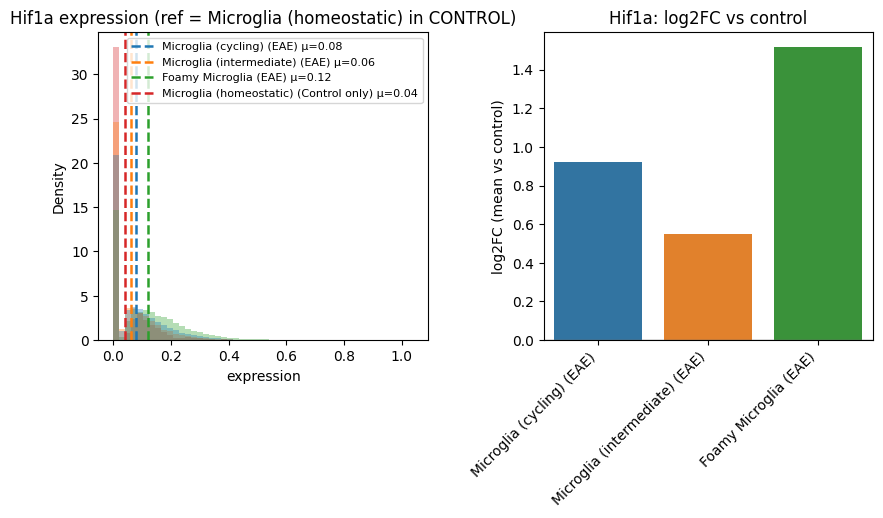

/var/folders/pm/2253tbm54v36j0l7lhshq73r0000gn/T/ipykernel_7114/1923675709.py:123: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_fc, x="group", y="log2FC",
/var/folders/pm/2253tbm54v36j0l7lhshq73r0000gn/T/ipykernel_7114/1923675709.py:138: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


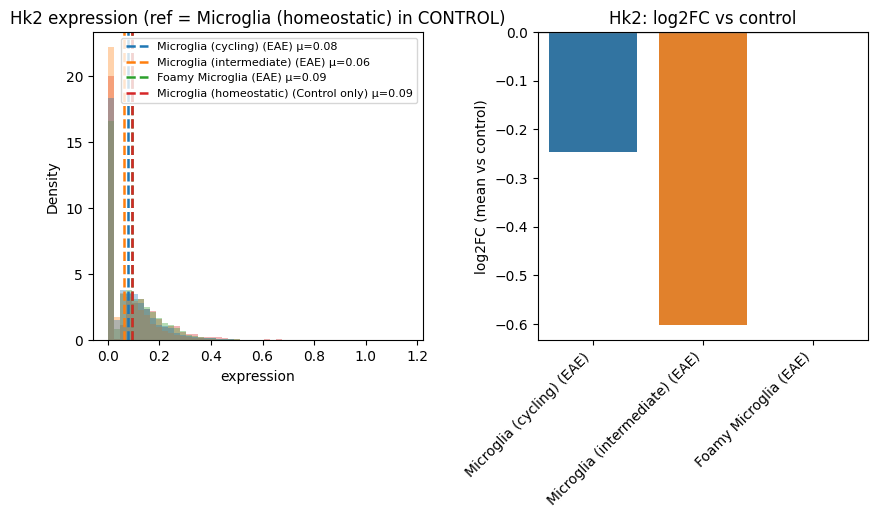

/var/folders/pm/2253tbm54v36j0l7lhshq73r0000gn/T/ipykernel_7114/1923675709.py:123: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_fc, x="group", y="log2FC",
/var/folders/pm/2253tbm54v36j0l7lhshq73r0000gn/T/ipykernel_7114/1923675709.py:138: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


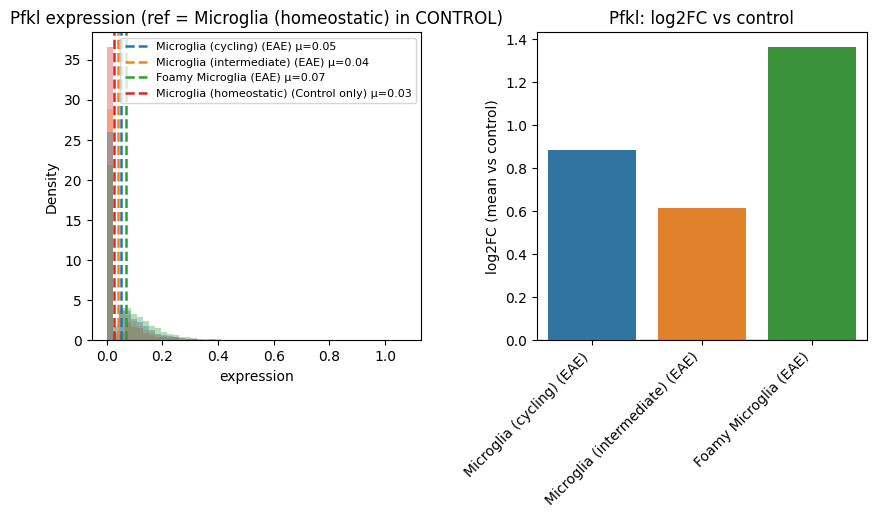

/var/folders/pm/2253tbm54v36j0l7lhshq73r0000gn/T/ipykernel_7114/1923675709.py:123: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_fc, x="group", y="log2FC",
/var/folders/pm/2253tbm54v36j0l7lhshq73r0000gn/T/ipykernel_7114/1923675709.py:138: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


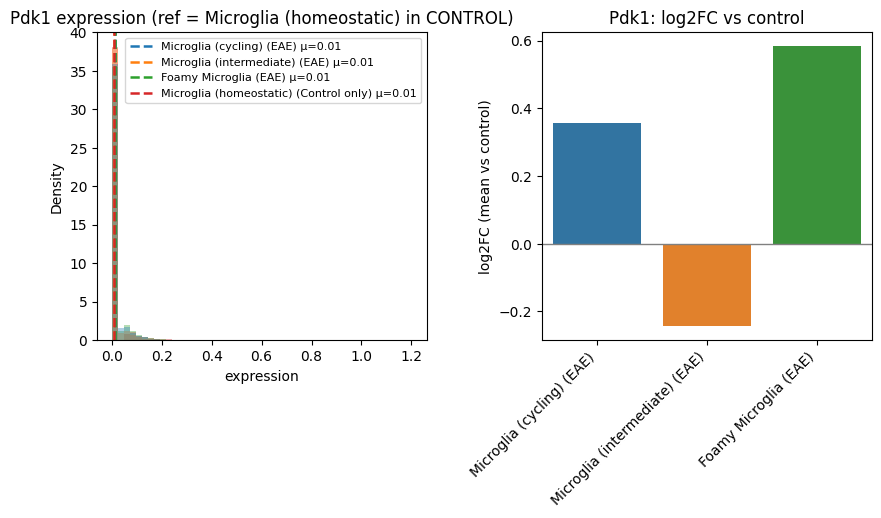

/var/folders/pm/2253tbm54v36j0l7lhshq73r0000gn/T/ipykernel_7114/1923675709.py:123: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_fc, x="group", y="log2FC",
/var/folders/pm/2253tbm54v36j0l7lhshq73r0000gn/T/ipykernel_7114/1923675709.py:138: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


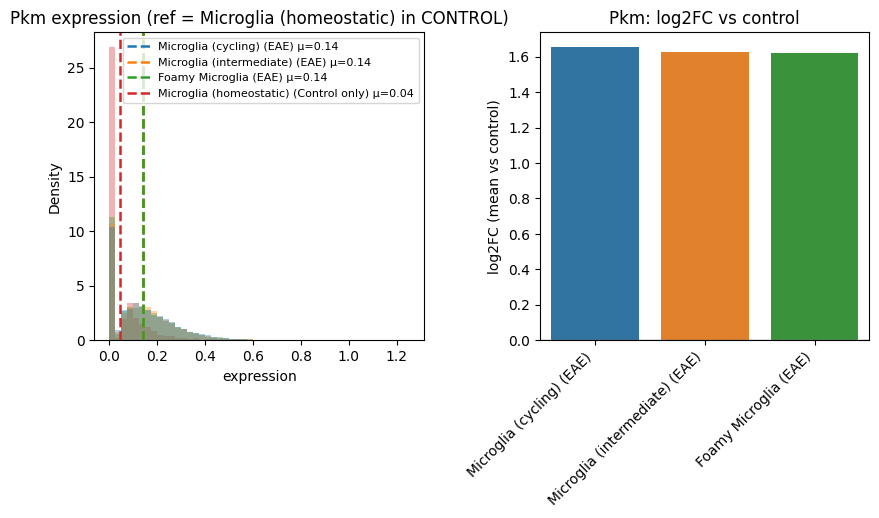

/var/folders/pm/2253tbm54v36j0l7lhshq73r0000gn/T/ipykernel_7114/1923675709.py:123: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_fc, x="group", y="log2FC",
/var/folders/pm/2253tbm54v36j0l7lhshq73r0000gn/T/ipykernel_7114/1923675709.py:138: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


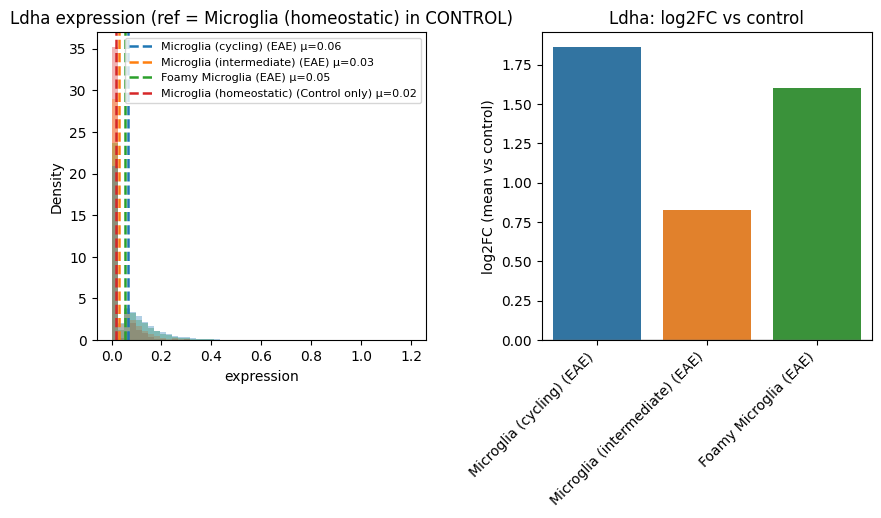

/var/folders/pm/2253tbm54v36j0l7lhshq73r0000gn/T/ipykernel_7114/1923675709.py:123: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_fc, x="group", y="log2FC",
/var/folders/pm/2253tbm54v36j0l7lhshq73r0000gn/T/ipykernel_7114/1923675709.py:138: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


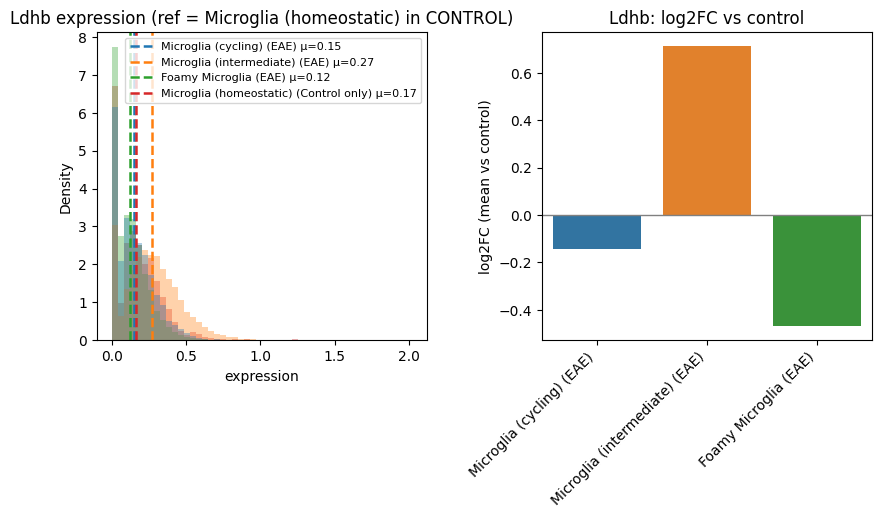

/var/folders/pm/2253tbm54v36j0l7lhshq73r0000gn/T/ipykernel_7114/1923675709.py:123: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_fc, x="group", y="log2FC",
/var/folders/pm/2253tbm54v36j0l7lhshq73r0000gn/T/ipykernel_7114/1923675709.py:138: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


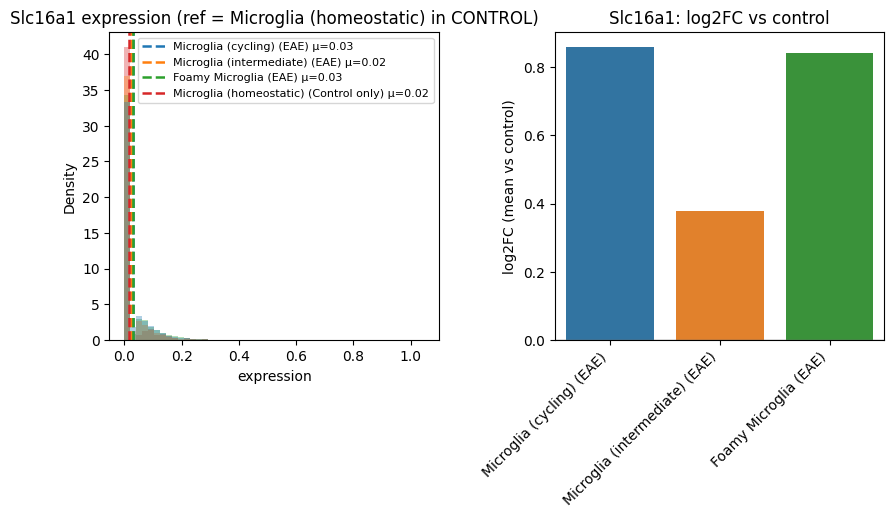

/var/folders/pm/2253tbm54v36j0l7lhshq73r0000gn/T/ipykernel_7114/1923675709.py:123: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_fc, x="group", y="log2FC",
/var/folders/pm/2253tbm54v36j0l7lhshq73r0000gn/T/ipykernel_7114/1923675709.py:138: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


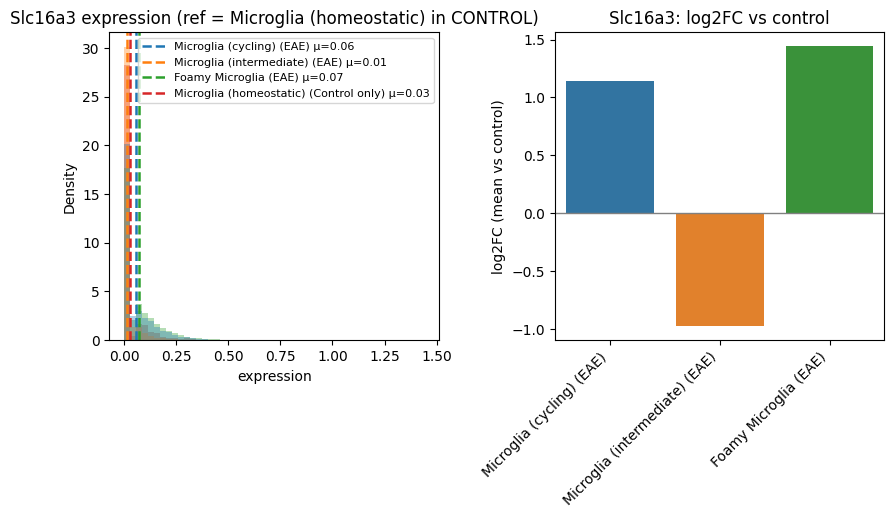

/var/folders/pm/2253tbm54v36j0l7lhshq73r0000gn/T/ipykernel_7114/1923675709.py:123: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_fc, x="group", y="log2FC",
/var/folders/pm/2253tbm54v36j0l7lhshq73r0000gn/T/ipykernel_7114/1923675709.py:138: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


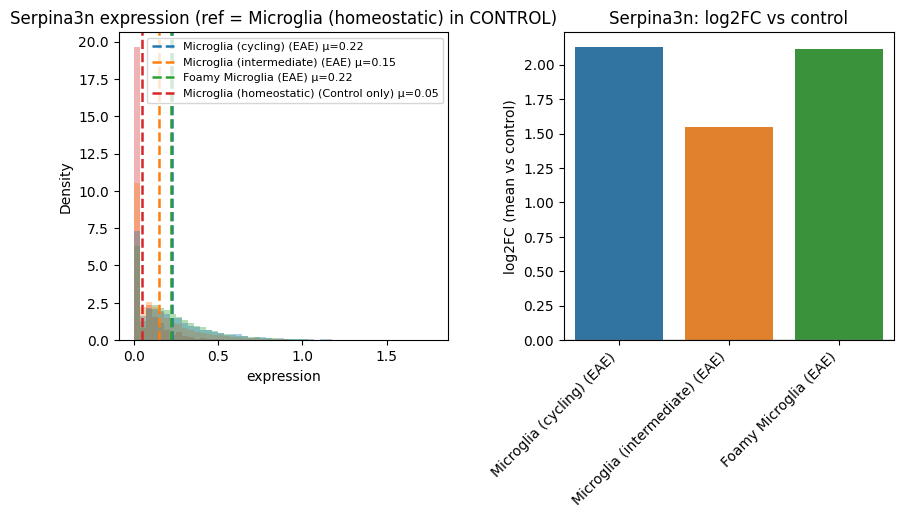

/var/folders/pm/2253tbm54v36j0l7lhshq73r0000gn/T/ipykernel_7114/1923675709.py:123: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_fc, x="group", y="log2FC",
/var/folders/pm/2253tbm54v36j0l7lhshq73r0000gn/T/ipykernel_7114/1923675709.py:138: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


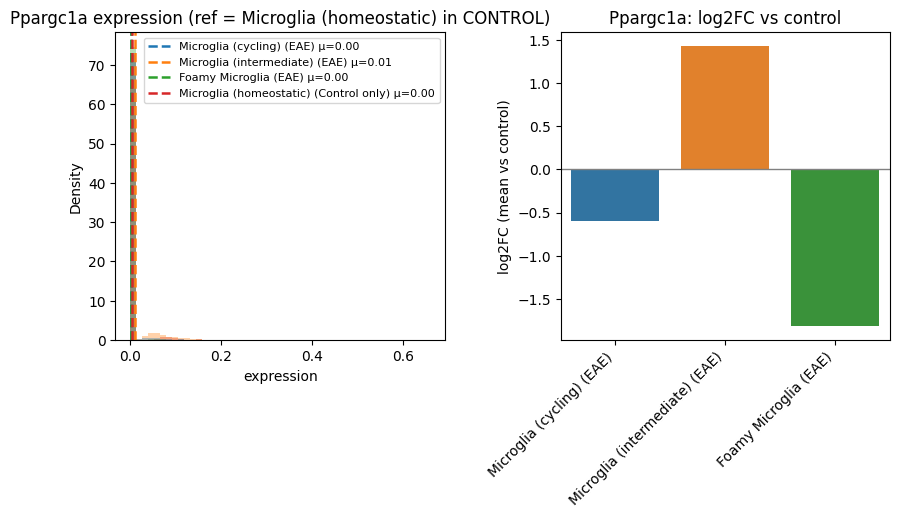

/var/folders/pm/2253tbm54v36j0l7lhshq73r0000gn/T/ipykernel_7114/1923675709.py:123: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_fc, x="group", y="log2FC",
/var/folders/pm/2253tbm54v36j0l7lhshq73r0000gn/T/ipykernel_7114/1923675709.py:138: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


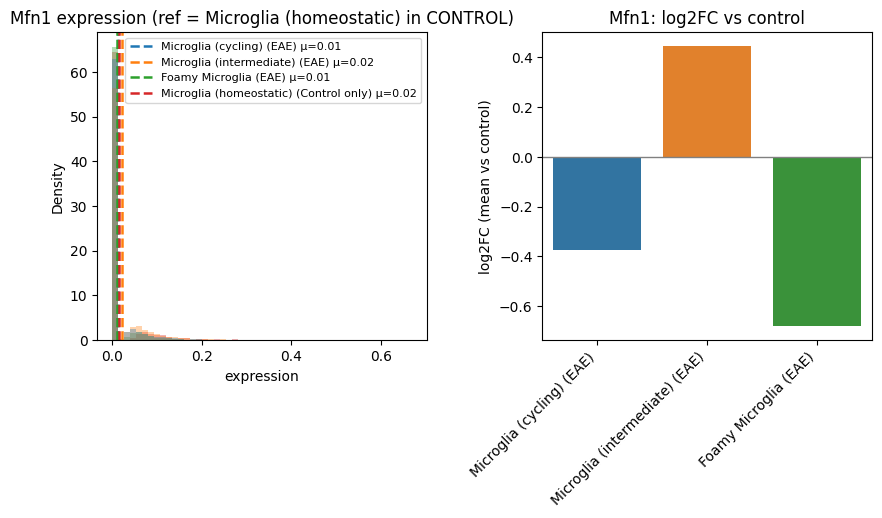

/var/folders/pm/2253tbm54v36j0l7lhshq73r0000gn/T/ipykernel_7114/1923675709.py:123: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_fc, x="group", y="log2FC",
/var/folders/pm/2253tbm54v36j0l7lhshq73r0000gn/T/ipykernel_7114/1923675709.py:138: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


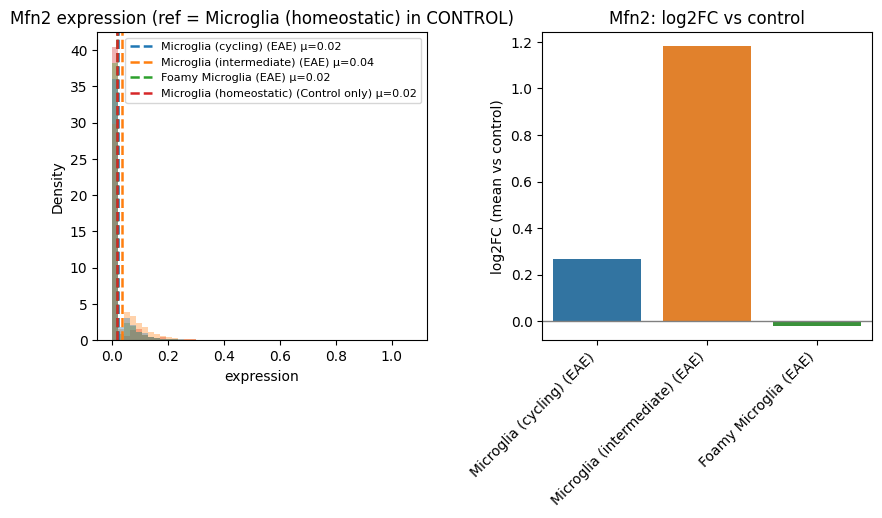

/var/folders/pm/2253tbm54v36j0l7lhshq73r0000gn/T/ipykernel_7114/1923675709.py:123: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_fc, x="group", y="log2FC",
/var/folders/pm/2253tbm54v36j0l7lhshq73r0000gn/T/ipykernel_7114/1923675709.py:138: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


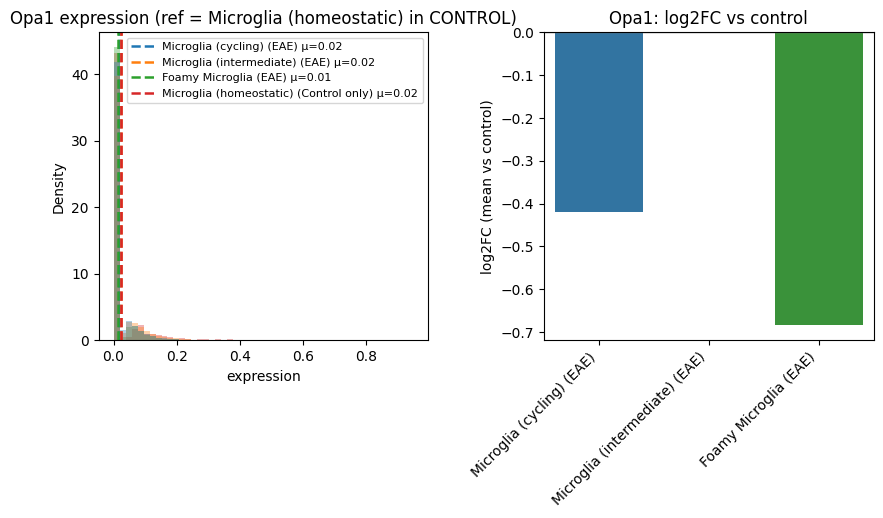

/var/folders/pm/2253tbm54v36j0l7lhshq73r0000gn/T/ipykernel_7114/1923675709.py:123: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_fc, x="group", y="log2FC",
/var/folders/pm/2253tbm54v36j0l7lhshq73r0000gn/T/ipykernel_7114/1923675709.py:138: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


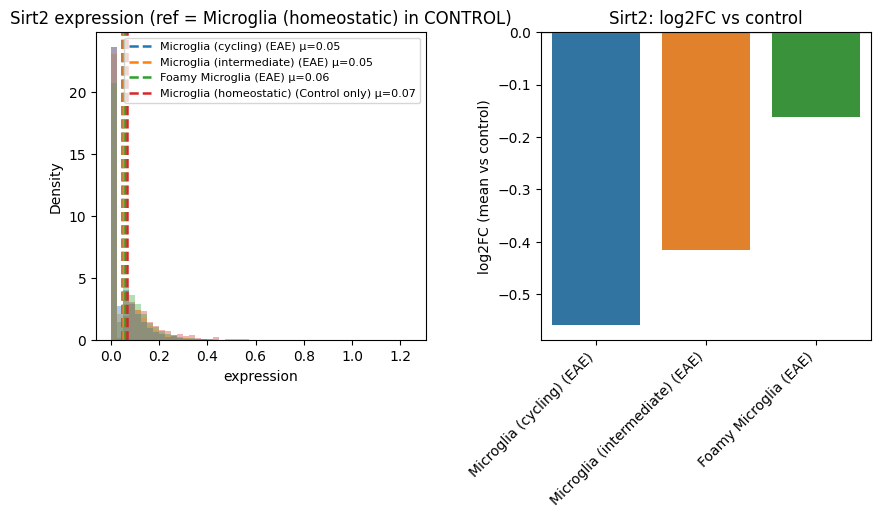

In [127]:

_ = plot_gene_expr_with_control_ref_and_fc(
    adata,
    genes=genes,
    groupby="sub_type_III",
    reference="Microglia (homeostatic)",          # baseline cluster
    condition_col="condition",       # e.g., "condition" ∈ {"Control","EAE"}
    control_value="CONTROL",         # take reference from Control only
    target_condition="EAE",          # (optional) restrict non-reference groups to EAE
    celltype_pattern="Micro",        # keep only astro rows
    use_raw=False,                     # assumes adata.raw = log1p normalized
    bins=50,
)